# Example of Graph Neural Network

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../..")
device = "cuda" if torch.cuda.is_available() else "cpu"

## Setup

In [2]:
from LightningModules.GNN.Models.interaction_gnn import InteractionGNN
from LightningModules.GNN.Models.checkpoint_pyramid import CheckpointedPyramid

In [6]:
with open("example_gnn_redux.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [7]:
model = InteractionGNN(hparams)

## Dataset Validation

In [8]:
%%time
model.setup(stage="fit")

Setting up dataset
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


Events loaded!


100it [00:04, 22.01it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val


100%|██████████| 20/20 [00:01<00:00, 16.14it/s]


Events loaded!


20it [00:01, 16.00it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test


100%|██████████| 10/10 [00:00<00:00, 14.67it/s]


Events loaded!


10it [00:00, 14.58it/s]

Events processed!
CPU times: user 13.9 s, sys: 1.92 s, total: 15.9 s
Wall time: 15.3 s


In [9]:
sample = model.trainset[0]

In [10]:
sample

Data(x=[104989, 3], cell_data=[104989, 11], pid=[104989], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000013836', hid=[104989], pt=[104989], primary=[104989], nhits=[104989], modulewise_true_edges=[2, 41708], signal_true_edges=[2, 5244], edge_index=[2, 32440], y=[32440], pedigree=[1], y_pid=[32440], pid_signal=[32440], scores=[32440])

In [11]:
sample.scores.shape

torch.Size([32440])

In [28]:
cut = 0.3

In [29]:
(sample.scores > cut).sum()

tensor(21841)

In [30]:
((sample.scores > cut) & sample.y.bool()).sum()

tensor(4728)

In [31]:
((sample.scores > cut) & sample.y_pid.bool()).sum()

tensor(12549)

In [32]:
((sample.scores > cut) & sample.pid_signal.bool()).sum()

tensor(7731)

In [33]:
((sample.scores > cut) & sample.pid_signal.bool()).sum() / sample.pid_signal.sum()

tensor(0.9747)

In [34]:
((sample.scores > cut) & sample.pid_signal.bool()).sum() / (sample.scores > cut).sum()

tensor(0.3540)

In [35]:
((sample.scores > cut) & sample.y_pid.bool()).sum() / (sample.scores > cut).sum()

tensor(0.5746)

In [37]:
positive, true, matching_true_positive, signal_true_positive = [], [], [], []

for event in model.trainset:
    positive.append((event.scores > cut).sum())
    true.append(event.pid_signal.sum())
    matching_true_positive.append((event.y_pid & (event.scores > cut)).sum())
    signal_true_positive.append((event.pid_signal & (event.scores > cut)).sum())
    
positive, true, matching_true_positive, signal_true_positive = np.array(positive), np.array(true), np.array(matching_true_positive), np.array(signal_true_positive)

In [41]:
np.mean(signal_true_positive) / np.mean(true), np.mean(signal_true_positive) / np.mean(positive), np.mean(matching_true_positive) / np.mean(positive)

(0.9772349010436815, 0.3819314322012624, 0.5972056751949929)

In [44]:
np.mean(signal_true_positive), np.mean(matching_true_positive), np.mean(true), np.mean(positive)

(8261.28, 12917.72, 8453.73, 21630.27)

In [45]:
np.std(signal_true_positive), np.std(matching_true_positive), np.std(true), np.std(positive)

(1088.5923394916942,
 1571.6072160689514,
 1133.5266988915614,
 3495.5986636197244)

### Input Graphs

In [65]:
graph_sizes = []

for graph in model.trainset:
    graph_sizes.append(graph.edge_index.shape[1])

<AxesSubplot:ylabel='Count'>

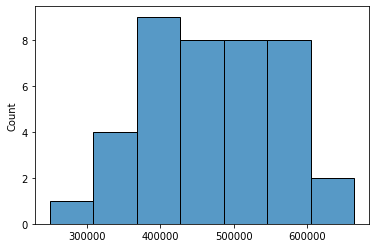

In [66]:
sns.histplot(graph_sizes)

In [74]:
graph_sizes = []

for graph in model.trainset:
    graph_sizes.append((graph.scores > cut).sum().item())

<AxesSubplot:ylabel='Count'>

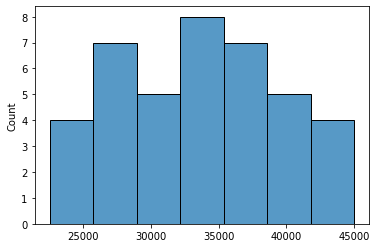

In [75]:
sns.histplot(graph_sizes)

## Train GNN

In [5]:
logger = WandbLogger(
    project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=hparams["max_epochs"], logger=logger
)  # , precision=16)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Setting up dataset
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train


  0%|          | 4/1000 [00:00<00:31, 31.48it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2940
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8484
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3096
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2383
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1934
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8213


  1%|          | 8/1000 [00:00<00:40, 24.22it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3227
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1311
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5697
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0599
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6686
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5657


  2%|▏         | 15/1000 [00:00<00:36, 26.95it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4019
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0381
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5096
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2543
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8449


  2%|▏         | 22/1000 [00:00<00:35, 27.65it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1251
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1255
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1210
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4143
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3174
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1442
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1785


  3%|▎         | 26/1000 [00:00<00:31, 30.81it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0623
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4114
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2215
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5182
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2807
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8300


  3%|▎         | 30/1000 [00:01<00:33, 29.05it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3053


  3%|▎         | 34/1000 [00:01<00:31, 30.21it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3839
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5448
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2714
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0551
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1240
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3240


  4%|▍         | 41/1000 [00:01<00:33, 28.24it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2640
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3151
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0697
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0725
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0402
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5986
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3958


  5%|▍         | 49/1000 [00:01<00:29, 32.03it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5415
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2889
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1223
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4082
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2686
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3621
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3733


  5%|▌         | 53/1000 [00:01<00:31, 30.19it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6659
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3820
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0125
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3064
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3840
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4128


  6%|▌         | 57/1000 [00:01<00:29, 31.86it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3581
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2773


  6%|▌         | 61/1000 [00:02<00:29, 31.66it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5922
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6570
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5991
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3245
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6083


  6%|▋         | 65/1000 [00:02<00:33, 28.31it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4139
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4293
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4651
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3715
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7822


  7%|▋         | 69/1000 [00:02<00:34, 27.33it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1716


  7%|▋         | 73/1000 [00:02<00:31, 29.23it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2204
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0214
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6377
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1570
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1117
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3120
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2776


  8%|▊         | 77/1000 [00:02<00:31, 28.91it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1035
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4318
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5687


  8%|▊         | 80/1000 [00:02<00:37, 24.62it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7986


  8%|▊         | 84/1000 [00:02<00:33, 27.49it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2439
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1944
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3269
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1304
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2559
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2320
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7328


  9%|▉         | 92/1000 [00:03<00:30, 29.69it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4456
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6247
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7623
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8406
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2755
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0628


 10%|▉         | 96/1000 [00:03<00:35, 25.59it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0516
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3885
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8566
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8131
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3985
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4158


 10%|█         | 103/1000 [00:03<00:32, 27.84it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5544
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7869
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2194
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2103
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4196
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5210


 11%|█         | 110/1000 [00:03<00:30, 28.80it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3530
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2806
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4519
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1425
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3535
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4979
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2258


 12%|█▏        | 118/1000 [00:04<00:29, 29.97it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0803
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6162
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7969
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2733
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6365
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0617
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4464


 13%|█▎        | 126/1000 [00:04<00:29, 29.75it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2824
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6400
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0103
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5999
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3969
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7660
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3901


 13%|█▎        | 130/1000 [00:04<00:28, 30.46it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8418
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6354
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8042
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7899
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4210
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5958
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1335


 14%|█▍        | 138/1000 [00:04<00:26, 32.52it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3394
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6230
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6047
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3607
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3589
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2039
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1061
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2009


 15%|█▍        | 146/1000 [00:05<00:28, 30.30it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5228
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1813
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2094
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5775
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1476
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0171


 15%|█▌        | 150/1000 [00:05<00:29, 28.90it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3729
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3541
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6666
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8327


 15%|█▌        | 153/1000 [00:05<00:34, 24.73it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4046
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7890
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6617
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2068


 16%|█▌        | 160/1000 [00:05<00:32, 25.73it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5213
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7178
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8016
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3482
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6838
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6137
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3854


 17%|█▋        | 167/1000 [00:05<00:31, 26.16it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8039
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0386
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1777
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7911
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2760
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4130


 18%|█▊        | 175/1000 [00:06<00:28, 29.33it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0656
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2360
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6280
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8060
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4580
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7258
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2754


 18%|█▊        | 179/1000 [00:06<00:27, 30.14it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0853
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1438
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5474
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3982
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4214
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0947
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5931


 19%|█▊        | 187/1000 [00:06<00:28, 28.71it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4121
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7894
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2572
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4881
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7046
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5234


 19%|█▉        | 191/1000 [00:06<00:26, 30.72it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1145
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7635
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1329
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1439
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2548
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3979


 20%|█▉        | 198/1000 [00:06<00:33, 23.86it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0053
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4084
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7122
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6361


 20%|██        | 202/1000 [00:07<00:30, 25.98it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7244
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2881
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5581
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4680
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3217
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1381


 21%|██        | 209/1000 [00:07<00:31, 25.33it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2056
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2024
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3005
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1662
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7594
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2414


 22%|██▏       | 217/1000 [00:07<00:27, 28.81it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5733
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5146
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7088
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2576
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7477
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2436
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0404


 22%|██▏       | 220/1000 [00:07<00:29, 26.80it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8326
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2966
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4412
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2942
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6504


 23%|██▎       | 228/1000 [00:08<00:27, 28.56it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3171
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5219
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7489
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3926
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3472
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7737
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3696


 24%|██▎       | 236/1000 [00:08<00:24, 30.78it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5270
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7787
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5718
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3552
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3234
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5244
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2300


 24%|██▍       | 240/1000 [00:08<00:27, 27.84it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6390
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0904
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1846
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6811
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6880


 24%|██▍       | 244/1000 [00:08<00:26, 28.91it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8360
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6518
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6447
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1039
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4591


 25%|██▌       | 251/1000 [00:08<00:26, 27.78it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1947
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4064
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6972
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6857
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7875
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4364
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4376


 26%|██▌       | 259/1000 [00:09<00:25, 28.83it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8561
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3993
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1266
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2438
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5211
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0724


 26%|██▋       | 263/1000 [00:09<00:24, 30.36it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7382
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6700
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4771
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6552
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0938
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4769
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1783


 27%|██▋       | 271/1000 [00:09<00:25, 28.91it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4608
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6744
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7755
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5885
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3647
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5484


 28%|██▊       | 279/1000 [00:09<00:23, 30.57it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1080
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6010
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7397
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3732
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2671
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7387
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1546


 28%|██▊       | 283/1000 [00:09<00:23, 30.88it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4734
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2278
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0260
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7141
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2892
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5006
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2908


 29%|██▉       | 290/1000 [00:10<00:28, 25.27it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2532
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6860
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3692
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3252
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3579


 30%|██▉       | 297/1000 [00:10<00:25, 27.42it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4103
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4701
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5376
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6753
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5461
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2562


 30%|███       | 301/1000 [00:10<00:24, 28.65it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3444
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7485
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1146
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4646
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5016
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2897
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5290


 31%|███       | 309/1000 [00:10<00:24, 28.01it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3937
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1717
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6051
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1931
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0116
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1681


 32%|███▏      | 317/1000 [00:11<00:22, 30.86it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7690
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4242
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5536
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2020
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6250
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2200
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6742


 32%|███▏      | 321/1000 [00:11<00:23, 29.29it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2998
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1026
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4350
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6559
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0151
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1663


 33%|███▎      | 327/1000 [00:11<00:26, 25.61it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5485
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0153
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6900
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2016
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2323
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2927


 33%|███▎      | 334/1000 [00:11<00:26, 24.99it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3366
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1348
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3464
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8290
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7983
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4821


 34%|███▍      | 342/1000 [00:12<00:23, 28.39it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5253
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1513
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0317
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6327
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1530
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7570
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5427


 35%|███▍      | 346/1000 [00:12<00:21, 30.97it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7337
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5870
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8109
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5152
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8121
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3219
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5638


 35%|███▌      | 354/1000 [00:12<00:20, 31.25it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6798
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0314
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5274
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2915
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4660
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6345
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1155


 36%|███▌      | 358/1000 [00:12<00:20, 31.76it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2051
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5240
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7152
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7202
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0334


 36%|███▋      | 365/1000 [00:12<00:26, 24.10it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0294
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1766
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8432
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1949


 37%|███▋      | 368/1000 [00:13<00:27, 22.78it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4105
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1584
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2531
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4825
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8168


 37%|███▋      | 374/1000 [00:13<00:29, 21.26it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3493
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7697
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7943
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7078
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2922
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8470


 38%|███▊      | 381/1000 [00:13<00:25, 24.72it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1221
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5676
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6760
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6256
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7388
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1834
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6681


 39%|███▉      | 388/1000 [00:13<00:22, 27.42it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6097
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4107
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6609
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2370
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4503
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6312
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3741


 40%|███▉      | 397/1000 [00:14<00:18, 33.38it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7937
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8502
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5306
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2883
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2616
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7384
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2289
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6669


 40%|████      | 401/1000 [00:14<00:18, 33.12it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5546
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0587
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4755
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4150
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0561


 41%|████      | 409/1000 [00:14<00:19, 30.20it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3540
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6388
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7222
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7601
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4472
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1468
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1932


 42%|████▏     | 417/1000 [00:14<00:18, 31.51it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1317
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3312
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6016
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8159
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8001
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2164
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2092


 42%|████▏     | 421/1000 [00:14<00:19, 29.38it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3453
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0160
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0549
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6087
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1010
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3025


 43%|████▎     | 428/1000 [00:15<00:18, 30.81it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4914
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8568
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2336
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8425
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7453
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5904
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7318


 44%|████▎     | 436/1000 [00:15<00:17, 32.01it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7733
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2063
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4561
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3433
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1762
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0075
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2799


 44%|████▍     | 440/1000 [00:15<00:18, 31.02it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4622
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1481
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2674
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4481
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5095


 45%|████▍     | 448/1000 [00:15<00:19, 28.65it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3900
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1730
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0514
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7887
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2066
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4312
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6567


 45%|████▌     | 452/1000 [00:15<00:18, 29.44it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0900
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7356
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1998
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4704


 46%|████▌     | 460/1000 [00:16<00:21, 25.53it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0365
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4939
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4301
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1771
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0448
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6684
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1705


 47%|████▋     | 467/1000 [00:16<00:19, 27.05it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5049
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2183
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2472
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0848
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6802
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2249
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7681


 47%|████▋     | 471/1000 [00:16<00:18, 28.05it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6446
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5104
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5754
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3852
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3748
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8587


 48%|████▊     | 477/1000 [00:16<00:20, 25.11it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5561
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7188
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7613
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2261


 48%|████▊     | 480/1000 [00:17<00:24, 20.93it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5950
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3957
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1316
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6663
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6965


 49%|████▊     | 487/1000 [00:17<00:21, 23.80it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3555
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7048
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5850
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0960
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7325
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3836
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8277


 50%|████▉     | 495/1000 [00:17<00:18, 27.92it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3639
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5360
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8476
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0588
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4961
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0994
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8461


 50%|█████     | 503/1000 [00:17<00:16, 30.17it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2229
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1131
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4290
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0164
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4276
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5623
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3661


 51%|█████     | 507/1000 [00:18<00:17, 27.73it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3348
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4824
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0554
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5615
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4033
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0394


 51%|█████▏    | 514/1000 [00:18<00:17, 27.04it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0998
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6234
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3556
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6776
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8596
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6642


 52%|█████▏    | 521/1000 [00:18<00:18, 25.93it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5374
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0826
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3817
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6827
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1062
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0503


 52%|█████▎    | 525/1000 [00:18<00:16, 27.95it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5079
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1591
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3622
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8513
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4009
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7610
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8107


 53%|█████▎    | 533/1000 [00:19<00:15, 31.11it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5805
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5248
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6693
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6484
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1574
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8388
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7206
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6316


 54%|█████▍    | 541/1000 [00:19<00:14, 31.89it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0644
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0123
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4557
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5909
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1452
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8372
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6783


 55%|█████▍    | 549/1000 [00:19<00:13, 33.42it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2389
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2179
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7458
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5565
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4445
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0739
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2615


 56%|█████▌    | 557/1000 [00:19<00:14, 31.17it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7267
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8232
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6619
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4616
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7437
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1588
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1169


 56%|█████▌    | 561/1000 [00:19<00:13, 31.52it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4003
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5078
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3500
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1979
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8088
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7492
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0049


 56%|█████▋    | 565/1000 [00:20<00:14, 30.92it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2660
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7400
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2002
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6423


 57%|█████▋    | 573/1000 [00:20<00:15, 27.55it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2060
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8525
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2956
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8134
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0756
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0185
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7336


 58%|█████▊    | 581/1000 [00:20<00:14, 29.90it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1067
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7327
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6678
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6871
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6313
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2826
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4262


 59%|█████▉    | 589/1000 [00:20<00:12, 31.86it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4551
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5899
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0645
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4116
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3197
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8289
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5307


 59%|█████▉    | 593/1000 [00:20<00:12, 32.04it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6094
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4588
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0337
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6536
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7653
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0931


 60%|██████    | 601/1000 [00:21<00:13, 30.11it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0458
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1867
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1195
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6274
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8524
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1956


 60%|██████    | 605/1000 [00:21<00:15, 26.28it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5993
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4549
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2636
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6641
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1384


 61%|██████    | 612/1000 [00:21<00:14, 26.78it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0688
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0357
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0888
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0128
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2809
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7379


 62%|██████▏   | 615/1000 [00:21<00:14, 25.77it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4359
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3425
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6449
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3319
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5698


 62%|██████▏   | 622/1000 [00:22<00:13, 28.23it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0410
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7295
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7250
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5673
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4010
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3894
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6708
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0340


 63%|██████▎   | 629/1000 [00:22<00:13, 28.24it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2413
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6237
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5102
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6302
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0510
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4677
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1151


 64%|██████▎   | 636/1000 [00:22<00:13, 27.43it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1935
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0578
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6145
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3413
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6526
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3417


 64%|██████▍   | 640/1000 [00:22<00:12, 28.50it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8480
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3081
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4576
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8186


 65%|██████▍   | 647/1000 [00:23<00:13, 26.06it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0097
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7451
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1063
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1737
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6043
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2257


 65%|██████▌   | 653/1000 [00:23<00:14, 23.31it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7430
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1756
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5165
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1936
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0652


 66%|██████▌   | 657/1000 [00:23<00:13, 26.02it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2209
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7260
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6370
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5594
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0824
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6096


 66%|██████▋   | 663/1000 [00:23<00:15, 21.61it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0399
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3419
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5919
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2286


 67%|██████▋   | 666/1000 [00:23<00:15, 21.90it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8304
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6707
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6493
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4300
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8052


 67%|██████▋   | 672/1000 [00:24<00:13, 23.81it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3952
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2891
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8534
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8358
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6961


 68%|██████▊   | 679/1000 [00:24<00:12, 24.90it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5566
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1192
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1102
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5654
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4981
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5133


 68%|██████▊   | 685/1000 [00:24<00:12, 25.00it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1058
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6142
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2921
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1589
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2827
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4353


 69%|██████▉   | 688/1000 [00:24<00:16, 18.87it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2972
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7304
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4811


 69%|██████▉   | 692/1000 [00:24<00:13, 22.35it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0384
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1212
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7842
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5081
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1054
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8179


 70%|██████▉   | 699/1000 [00:25<00:11, 25.73it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4299
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3089
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1659
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0820
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5060
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5328
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2613


 71%|███████   | 706/1000 [00:25<00:11, 26.36it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5968
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7197
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0131
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5477
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6957
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1733


 71%|███████   | 710/1000 [00:25<00:10, 27.31it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6197
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4056
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6205
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7072
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1845


 72%|███████▏  | 716/1000 [00:25<00:12, 23.52it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8025
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5289
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1262
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7511
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5480


 72%|███████▏  | 723/1000 [00:26<00:10, 25.91it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7068
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5822
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4484
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6644
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1862
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0948
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4334
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1611


 73%|███████▎  | 730/1000 [00:26<00:11, 23.08it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0524
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2453
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3140
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1122
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5151
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7720
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2228


 74%|███████▎  | 737/1000 [00:26<00:11, 23.54it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4252
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0191
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7644
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7428
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5141


 74%|███████▍  | 745/1000 [00:27<00:08, 28.64it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8373
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7216
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8206
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5346
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7946
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7909
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7910
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6564
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6304


 75%|███████▍  | 749/1000 [00:27<00:13, 18.64it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0231
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4509
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4645
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6295
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6794
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6648


 76%|███████▌  | 756/1000 [00:27<00:11, 21.32it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1279
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6173
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0257
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4590
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4798


 76%|███████▋  | 763/1000 [00:28<00:10, 22.94it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5497
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5051
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4231
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5523
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1881
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4703
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3181


 77%|███████▋  | 766/1000 [00:28<00:12, 18.75it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3913
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7211
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4078
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4909


 77%|███████▋  | 772/1000 [00:28<00:11, 19.70it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0136
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0680
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2561
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6036
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3897
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0683


 78%|███████▊  | 779/1000 [00:28<00:09, 22.74it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3006
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0095
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3720
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0715
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1178


 78%|███████▊  | 783/1000 [00:28<00:08, 25.07it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6441
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5809
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5252
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7673
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6029
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6481
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0937


 79%|███████▉  | 791/1000 [00:29<00:07, 28.54it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3922
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5827
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2952
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4853
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5930
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3308
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1796


 80%|███████▉  | 799/1000 [00:29<00:07, 28.10it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4090
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6886
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4729
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0673
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2131
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0671


 80%|████████  | 802/1000 [00:29<00:07, 27.50it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0717
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1647
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3626
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1168
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1124
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2302


 81%|████████  | 809/1000 [00:29<00:07, 26.98it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7692
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0597
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2887
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7353
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5964
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2895


 82%|████████▏ | 816/1000 [00:30<00:07, 25.49it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2318
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4740
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8236
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3698
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0829


 82%|████████▏ | 819/1000 [00:30<00:07, 23.87it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7664
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8485
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7862
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8105
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0223
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3347


 83%|████████▎ | 826/1000 [00:30<00:06, 24.93it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7833
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6228
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3708
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5314
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5170
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7999


 83%|████████▎ | 830/1000 [00:30<00:06, 27.42it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3593
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7867
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8148
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8592
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3414


 84%|████████▍ | 838/1000 [00:30<00:05, 28.19it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6646
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0319
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8224
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0427
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5808
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8190
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1081


 84%|████████▍ | 845/1000 [00:31<00:05, 27.96it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1282
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4255
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1602
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0800
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7156


 85%|████████▍ | 848/1000 [00:31<00:06, 23.92it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7793
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7066
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0674
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1930
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3735
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6810


 86%|████████▌ | 856/1000 [00:31<00:05, 28.59it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2223
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8479
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1952
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3509
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2898
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3271
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1615


 86%|████████▋ | 864/1000 [00:31<00:04, 28.94it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4065
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4089
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2270
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5814
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5598
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8386


 87%|████████▋ | 871/1000 [00:32<00:04, 29.18it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2005
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8563
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7099
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2928
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0250
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3870
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4544


 88%|████████▊ | 875/1000 [00:32<00:04, 29.96it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5065
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6239
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5856
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0144
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2600
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7168


 88%|████████▊ | 883/1000 [00:32<00:03, 29.99it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1511
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0376
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1394
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0600
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0640
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4369
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4696
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2018


 89%|████████▉ | 890/1000 [00:32<00:03, 27.65it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4307
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4550
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4982
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2739
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3673


 89%|████████▉ | 894/1000 [00:32<00:03, 29.21it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7727
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7685
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6154
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0216
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6150
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1227
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4993


 90%|█████████ | 901/1000 [00:33<00:03, 27.30it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4200
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0052
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1008
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6125
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5239
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6363


 91%|█████████ | 909/1000 [00:33<00:02, 30.82it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1800
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8379
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0028
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5783
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2968
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8514
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2073


 91%|█████████▏| 913/1000 [00:33<00:02, 32.28it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8100
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0768
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4907
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3110
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1428
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4989


 92%|█████████▏| 921/1000 [00:33<00:02, 29.06it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3777
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3225
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5554
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7395
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4449
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4581
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4627


 92%|█████████▎| 925/1000 [00:33<00:02, 30.36it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8104
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4415
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4372
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1215


 93%|█████████▎| 934/1000 [00:34<00:02, 29.76it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1413
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7475
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4323
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3598
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7179
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2625
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5410
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0705
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7010


 94%|█████████▍| 944/1000 [00:34<00:01, 34.77it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3076
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4118
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1392
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7956
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5975
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1422
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8469
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3029


 95%|█████████▌| 953/1000 [00:34<00:01, 35.11it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6973
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4693
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0425
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2111
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0635
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0531
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3431
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1005
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5157


 96%|█████████▌| 961/1000 [00:34<00:01, 36.35it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4173
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5467
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6877
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/2819
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1708
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3520
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8253
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4785


 96%|█████████▋| 965/1000 [00:35<00:00, 37.26it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8031
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3062
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/0651
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1518
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1299
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7412


 97%|█████████▋| 969/1000 [00:35<00:01, 29.83it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4251
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5677
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6818
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6425
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1578


 98%|█████████▊| 978/1000 [00:35<00:00, 31.67it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6190
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4595
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3132
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6869
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1094
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6923
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3283
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8045
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7148


 98%|█████████▊| 983/1000 [00:35<00:00, 34.15it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3858
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/4068
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8351
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7459
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8507


 99%|█████████▉| 991/1000 [00:35<00:00, 32.12it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5781
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1520
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1843
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8049
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7952
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5839
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5819


100%|██████████| 1000/1000 [00:36<00:00, 27.57it/s]


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/1406
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/5929
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/6466
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/8518
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/3966
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/train/7391
Events loaded!


1000it [00:43, 22.78it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val


 10%|█         | 2/20 [00:00<00:01, 14.97it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/7023
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/8044
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/2418
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/4485


 30%|███       | 6/20 [00:00<00:00, 15.17it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/2125
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/0684
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/3724
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/0669


 50%|█████     | 10/20 [00:00<00:00, 15.54it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/1354
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/0509
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/5144
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/0188


 70%|███████   | 14/20 [00:00<00:00, 15.63it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/4764
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/2366
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/4498
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/0393


 90%|█████████ | 18/20 [00:01<00:00, 15.71it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/4837
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/3860
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/1804
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/val/0091


100%|██████████| 20/20 [00:01<00:00, 15.72it/s]


Events loaded!


20it [00:01, 13.03it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test


 20%|██        | 2/10 [00:00<00:00, 17.00it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/8329
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/0385
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/2288
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/5119


 60%|██████    | 6/10 [00:00<00:00, 16.36it/s]

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/1787
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/2859
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/1859
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/8261


100%|██████████| 10/10 [00:00<00:00, 16.34it/s]


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/5246
/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3/test/7783
Events loaded!


10it [00:00, 13.16it/s]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Events processed!


wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.9 K
1 | edge_encoder           | Sequential | 65.9 K
2 | edge_network           | Sequential | 82.3 K
3 | node_network           | Sequential | 82.3 K
4 | output_edge_classifier | Sequential | 82.4 K
------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.392     Total estimated model params size (MB)


Epoch 0:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.73it/s, loss=0.662, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 1:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.64it/s, loss=0.611, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 2:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.63it/s, loss=0.571, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.69it/s, loss=0.544, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 4:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.67it/s, loss=0.527, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 5:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.66it/s, loss=0.516, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 6:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.65it/s, loss=0.508, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 7:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.68it/s, loss=0.502, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 8:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.65it/s, loss=0.498,

Epoch 17:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.68it/s, loss=0.478, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 18:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.76it/s, loss=0.476, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 19:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.72it/s, loss=0.475, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 20:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.71it/s, loss=0.472, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 21:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.73it/s, loss=0.472, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 22:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.67it/s, loss=0.471, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 23:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.72it/s, loss=0.47, v_num=l6zc] 
Validating: 0it [00:00, ?it/s]
Epoch 24:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.70it/s, loss=0.47, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 25:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.64it/s, los

Epoch 33:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.63it/s, loss=0.464, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 34:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.63it/s, loss=0.463, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 35:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.68it/s, loss=0.463, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 36:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.66it/s, loss=0.462, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 37:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.71it/s, loss=0.462, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 38:  98%|█████████▊| 1000/1020 [01:56<00:02,  8.62it/s, loss=0.461, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 39:  98%|█████████▊| 1000/1020 [01:55<00:02,  8.63it/s, loss=0.461, v_num=l6zc]
Validating: 0it [00:00, ?it/s]
Epoch 40:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.73it/s, loss=0.46, v_num=l6zc] 
Validating: 0it [00:00, ?it/s]
Epoch 41:  98%|█████████▊| 1000/1020 [01:54<00:02,  8.76it/s, lo

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Build Classified Files

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Barrel_GNN/i7mwr3nr/checkpoints/epoch=74-step=29999.ckpt"
checkpoint = torch.load(checkpoint_path)

model = InteractionGNN.load_from_checkpoint(checkpoint_path).to(device)

In [4]:
model.eval();

In [6]:
model.hparams

"aggregation":       mean_max
"artifacts":         /global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints
"batchnorm":         False
"cell_channels":     11
"datatype_names":    ['train', 'val', 'test']
"datatype_split":    [1600, 50, 10]
"edge_cut":          0.5
"emb_channels":      0
"endcaps":           False
"factor":            0.7
"gpus":              4
"hidden":            128
"hidden_activation": SiLU
"input_dir":         /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3
"layernorm":         False
"lr":                0.002
"mask_background":   True
"max_epochs":        100
"model":             InteractionGNN
"n_graph_iters":     8
"nb_edge_layer":     3
"nb_node_layer":     3
"noise":             True
"output_dir":        /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0GeV_barrel_v3
"patience":          30
"project":           ITk_1GeVSignal_Barrel_GNN
"pt_background_cut": 0.0
"pt_signal_cut":     1000.0
"sorted_e

In [7]:
# model.hparams["datatype_split"] = [200, 1, 10]
model.setup(stage="fit")

Setting up dataset
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/train


100%|██████████| 1600/1600 [01:42<00:00, 15.58it/s]


Events loaded!


1600it [00:59, 27.06it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/val


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


Events loaded!


50it [00:02, 22.03it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/test


100%|██████████| 10/10 [00:00<00:00, 16.76it/s]


Events loaded!


10it [00:00, 21.05it/s]

Events processed!


In [8]:
model = model.to(device)

In [74]:
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for batch in model.train_dataloader():

        print(batch)

        output = model.shared_evaluation(batch.to(device), 0, log=False)

        print(output)
        print(os.path.split(batch.event_file[0])[-1])

        gnn_results = np.vstack(
            [
                batch.edge_index.cpu().numpy(),
                output["score"][: int(len(output["score"]) / 2)].cpu().numpy(),
                output["truth"].cpu().numpy(),
            ]
        )

        gnn_recarray = np.rec.fromarrays(
            gnn_results, names=["senders", "receivers", "score", "truth"]
        )

        with open(
            os.path.join(
                output_dir, os.path.split(batch.event_file[0])[-1][-4:] + ".npz"
            ),
            "wb",
        ) as f:
            np.save(f, gnn_recarray)

Batch(batch=[21428], cell_data=[21428, 11], edge_index=[2, 182327], event_file=[1], hid=[21428], modulewise_true_edges=[2, 17889], nhits=[21428], pid=[21428], primary=[21428], pt=[21428], ptr=[2], signal_true_edges=[2, 14822], x=[21428, 3], y=[182327], y_pid=[182327])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0277, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.8932e-02, 1.9480e-04, 2.3910e-04,  ..., 1.0017e-04, 2.6190e-05,
        4.1214e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010001
Batch(batch=[20316], cell_data=[20316, 11], edge_index=[2, 160427], event_file=[1], hid=[20316], modulewise_true_edges=[2, 16859], nhits=[20316], pid=[20316], primary=[20316], pt=[20316], ptr=[2], signal_true_edges=[2, 13654], x=[20316, 3], y=[160427], y_pid=[160427])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0301, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.6138e-03, 4.3948e-05, 1.0922e-04,  ..., 2.7575e-04, 2.6210e-04,
        2.8092e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010002
Batch(batch=[26360], cell_data=[26360, 11], edge_index=[2, 263389], event_file=[1], hid=[26360], modulewise_true_edges=[2, 21995], nhits=[26360], pid=[26360], primary=[26360], pt=[26360], ptr=[2], signal_true_edges=[2, 18093], x=[26360, 3], y=[263389], y_pid=[263389])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0263, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.8291e-03, 3.0076e-03, 3.2153e-04,  ..., 1.0838e-04, 3.1777e-05,
        4.8927e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010003
Batch(batch=[18174], cell_data=[18174, 11], edge_index=[2, 129874], event_file=[1], hid=[18174], modulewise_true_edges=[2, 15083], nhits=[18174], pid=[18174], primary=[18174], pt=[18174], ptr=[2], signal_true_edges=[2, 12223], x=[18174, 3], y=[129874], y_pid=[129874])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0307, device='cuda:0'), 'preds': tensor([False,  True, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([5.5092e-06, 8.9512e-01, 1.9343e-01,  ..., 6.6806e-01, 5.4391e-04,
        1.5399e-03], device='cuda:0'), 'truth': tensor([False,  True, False,  ..., False, False, False], device='cuda:0')}
event000010004
Batch(batch=[24514], cell_data=[24514, 11], edge_index=[2, 229935], event_file=[1], hid=[24514], modulewise_true_edges=[2, 20441], nhits=[24514], pid=[24514], primary=[24514], pt=[24514], ptr=[2], signal_true_edges=[2, 16733], x=[24514, 3], y=[229935], y_pid=[229935])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.7308e-05, 2.0252e-03, 1.1878e-05,  ..., 2.1065e-05, 3.6906e-05,
        1.4867e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010005
Batch(batch=[23987], cell_data=[23987, 11], edge_index=[2, 219135], event_file=[1], hid=[23987], modulewise_true_edges=[2, 19975], nhits=[23987], pid=[23987], primary=[23987], pt=[23987], ptr=[2], signal_true_edges=[2, 16222], x=[23987, 3], y=[219135], y_pid=[219135])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0284, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.8506e-04, 8.0432e-05, 6.9039e-02,  ..., 4.1239e-04, 3.3575e-05,
        1.8252e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010006
Batch(batch=[26395], cell_data=[26395, 11], edge_index=[2, 265622], event_file=[1], hid=[26395], modulewise_true_edges=[2, 21990], nhits=[26395], pid=[26395], primary=[26395], pt=[26395], ptr=[2], signal_true_edges=[2, 18135], x=[26395, 3], y=[265622], y_pid=[265622])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.9568e-03, 2.2322e-03, 1.2444e-04,  ..., 3.8781e-05, 5.6611e-05,
        2.4844e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010007
Batch(batch=[23642], cell_data=[23642, 11], edge_index=[2, 210727], event_file=[1], hid=[23642], modulewise_true_edges=[2, 19656], nhits=[23642], pid=[23642], primary=[23642], pt=[23642], ptr=[2], signal_true_edges=[2, 15961], x=[23642, 3], y=[210727], y_pid=[210727])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.1837e-03, 4.6246e-02, 1.4159e-04,  ..., 9.8720e-01, 4.9774e-05,
        5.9327e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010008
Batch(batch=[21644], cell_data=[21644, 11], edge_index=[2, 179556], event_file=[1], hid=[21644], modulewise_true_edges=[2, 18054], nhits=[21644], pid=[21644], primary=[21644], pt=[21644], ptr=[2], signal_true_edges=[2, 14731], x=[21644, 3], y=[179556], y_pid=[179556])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0282, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.8943e-05, 9.3955e-05, 2.6439e-05,  ..., 9.2367e-05, 5.7389e-03,
        1.1963e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010009
Batch(batch=[18579], cell_data=[18579, 11], edge_index=[2, 139011], event_file=[1], hid=[18579], modulewise_true_edges=[2, 15524], nhits=[18579], pid=[18579], primary=[18579], pt=[18579], ptr=[2], signal_true_edges=[2, 12736], x=[18579, 3], y=[139011], y_pid=[139011])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1584e-05, 1.9329e-03, 7.6443e-04,  ..., 3.9833e-05, 6.0347e-03,
        1.9427e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000010
Batch(batch=[23755], cell_data=[23755, 11], edge_index=[2, 215329], event_file=[1], hid=[23755], modulewise_true_edges=[2, 19805], nhits=[23755], pid=[23755], primary=[23755], pt=[23755], ptr=[2], signal_true_edges=[2, 16093], x=[23755, 3], y=[215329], y_pid=[215329])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.2475e-05, 2.1563e-04, 6.6669e-03,  ..., 6.9244e-05, 2.1823e-05,
        4.2965e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010011
Batch(batch=[24486], cell_data=[24486, 11], edge_index=[2, 230724], event_file=[1], hid=[24486], modulewise_true_edges=[2, 20471], nhits=[24486], pid=[24486], primary=[24486], pt=[24486], ptr=[2], signal_true_edges=[2, 16737], x=[24486, 3], y=[230724], y_pid=[230724])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.8733e-05, 5.9391e-05, 1.1947e-03,  ..., 2.1761e-05, 8.3078e-05,
        1.0664e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010012
Batch(batch=[27800], cell_data=[27800, 11], edge_index=[2, 290018], event_file=[1], hid=[27800], modulewise_true_edges=[2, 23195], nhits=[27800], pid=[27800], primary=[27800], pt=[27800], ptr=[2], signal_true_edges=[2, 19120], x=[27800, 3], y=[290018], y_pid=[290018])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0257, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.2905e-05, 2.1112e-05, 3.5255e-05,  ..., 3.2448e-05, 3.7968e-05,
        2.2730e-02], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000013
Batch(batch=[22254], cell_data=[22254, 11], edge_index=[2, 188603], event_file=[1], hid=[22254], modulewise_true_edges=[2, 18592], nhits=[22254], pid=[22254], primary=[22254], pt=[22254], ptr=[2], signal_true_edges=[2, 14831], x=[22254, 3], y=[188603], y_pid=[188603])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0312, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.1150e-01, 3.1438e-03, 4.6768e-02,  ..., 2.1072e-04, 8.9660e-05,
        1.5756e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000014
Batch(batch=[26079], cell_data=[26079, 11], edge_index=[2, 255023], event_file=[1], hid=[26079], modulewise_true_edges=[2, 21710], nhits=[26079], pid=[26079], primary=[26079], pt=[26079], ptr=[2], signal_true_edges=[2, 17521], x=[26079, 3], y=[255023], y_pid=[255023])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.0003e-05, 3.0932e-05, 5.0317e-04,  ..., 3.3822e-05, 4.3899e-04,
        1.6267e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010015
Batch(batch=[28271], cell_data=[28271, 11], edge_index=[2, 294995], event_file=[1], hid=[28271], modulewise_true_edges=[2, 23563], nhits=[28271], pid=[28271], primary=[28271], pt=[28271], ptr=[2], signal_true_edges=[2, 19285], x=[28271, 3], y=[294995], y_pid=[294995])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0253, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1327e-04, 9.9773e-05, 1.1746e-02,  ..., 1.0135e-04, 1.3799e-03,
        1.7338e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000016
Batch(batch=[20984], cell_data=[20984, 11], edge_index=[2, 178083], event_file=[1], hid=[20984], modulewise_true_edges=[2, 17572], nhits=[20984], pid=[20984], primary=[20984], pt=[20984], ptr=[2], signal_true_edges=[2, 14676], x=[20984, 3], y=[178083], y_pid=[178083])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9859e-05, 8.7187e-04, 3.1649e-04,  ..., 3.1234e-05, 2.5594e-05,
        4.3685e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010017
Batch(batch=[21778], cell_data=[21778, 11], edge_index=[2, 183149], event_file=[1], hid=[21778], modulewise_true_edges=[2, 18105], nhits=[21778], pid=[21778], primary=[21778], pt=[21778], ptr=[2], signal_true_edges=[2, 14739], x=[21778, 3], y=[183149], y_pid=[183149])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([3.9194e-05, 1.8531e-05, 3.3895e-04,  ..., 8.6424e-02, 9.2667e-01,
        7.2236e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010018
Batch(batch=[22293], cell_data=[22293, 11], edge_index=[2, 192130], event_file=[1], hid=[22293], modulewise_true_edges=[2, 18618], nhits=[22293], pid=[22293], primary=[22293], pt=[22293], ptr=[2], signal_true_edges=[2, 15249], x=[22293, 3], y=[192130], y_pid=[192130])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9632e-03, 6.7009e-04, 3.3854e-04,  ..., 3.8907e-05, 3.1622e-05,
        4.6801e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010019
Batch(batch=[20172], cell_data=[20172, 11], edge_index=[2, 160441], event_file=[1], hid=[20172], modulewise_true_edges=[2, 16722], nhits=[20172], pid=[20172], primary=[20172], pt=[20172], ptr=[2], signal_true_edges=[2, 13308], x=[20172, 3], y=[160441], y_pid=[160441])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0298, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True,  True, False], device='cuda:0'), 'score': tensor([4.2272e-05, 4.3531e-04, 4.1149e-05,  ..., 9.5398e-01, 9.6773e-01,
        4.3507e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True,  True, False], device='cuda:0')}
event000010020
Batch(batch=[24021], cell_data=[24021, 11], edge_index=[2, 219822], event_file=[1], hid=[24021], modulewise_true_edges=[2, 20020], nhits=[24021], pid=[24021], primary=[24021], pt=[24021], ptr=[2], signal_true_edges=[2, 16230], x=[24021, 3], y=[219822], y_pid=[219822])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.7873e-04, 4.3362e-04, 3.8116e-02,  ..., 3.4574e-05, 5.2713e-05,
        3.6613e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010021
Batch(batch=[23001], cell_data=[23001, 11], edge_index=[2, 207274], event_file=[1], hid=[23001], modulewise_true_edges=[2, 19226], nhits=[23001], pid=[23001], primary=[23001], pt=[23001], ptr=[2], signal_true_edges=[2, 15492], x=[23001, 3], y=[207274], y_pid=[207274])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9382e-04, 2.1594e-05, 2.9297e-03,  ..., 6.4310e-05, 2.7842e-05,
        2.2965e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010022
Batch(batch=[25299], cell_data=[25299, 11], edge_index=[2, 241603], event_file=[1], hid=[25299], modulewise_true_edges=[2, 21043], nhits=[25299], pid=[25299], primary=[25299], pt=[25299], ptr=[2], signal_true_edges=[2, 16918], x=[25299, 3], y=[241603], y_pid=[241603])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.9455e-05, 4.9416e-05, 7.0470e-04,  ..., 5.7158e-05, 1.8878e-03,
        1.0594e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010023
Batch(batch=[20795], cell_data=[20795, 11], edge_index=[2, 169503], event_file=[1], hid=[20795], modulewise_true_edges=[2, 17321], nhits=[20795], pid=[20795], primary=[20795], pt=[20795], ptr=[2], signal_true_edges=[2, 13960], x=[20795, 3], y=[169503], y_pid=[169503])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([ True, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.2110e-01, 2.3546e-05, 2.5641e-05,  ..., 2.1161e-05, 5.0279e-05,
        4.2146e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010024
Batch(batch=[24192], cell_data=[24192, 11], edge_index=[2, 224066], event_file=[1], hid=[24192], modulewise_true_edges=[2, 20247], nhits=[24192], pid=[24192], primary=[24192], pt=[24192], ptr=[2], signal_true_edges=[2, 16865], x=[24192, 3], y=[224066], y_pid=[224066])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0249, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.6826e-03, 4.4730e-02, 4.5096e-02,  ..., 2.3395e-04, 2.1430e-05,
        1.9421e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010025
Batch(batch=[21489], cell_data=[21489, 11], edge_index=[2, 178211], event_file=[1], hid=[21489], modulewise_true_edges=[2, 17876], nhits=[21489], pid=[21489], primary=[21489], pt=[21489], ptr=[2], signal_true_edges=[2, 14460], x=[21489, 3], y=[178211], y_pid=[178211])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4567e-04, 3.5458e-03, 1.7688e-02,  ..., 1.2180e-04, 1.3061e-02,
        4.0153e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010026
Batch(batch=[26647], cell_data=[26647, 11], edge_index=[2, 268852], event_file=[1], hid=[26647], modulewise_true_edges=[2, 22304], nhits=[26647], pid=[26647], primary=[26647], pt=[26647], ptr=[2], signal_true_edges=[2, 18506], x=[26647, 3], y=[268852], y_pid=[268852])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0243, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1196e-01, 8.7825e-02, 1.2804e-01,  ..., 2.9982e-05, 1.1824e-04,
        1.9726e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010027
Batch(batch=[20685], cell_data=[20685, 11], edge_index=[2, 169376], event_file=[1], hid=[20685], modulewise_true_edges=[2, 17289], nhits=[20685], pid=[20685], primary=[20685], pt=[20685], ptr=[2], signal_true_edges=[2, 14076], x=[20685, 3], y=[169376], y_pid=[169376])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0300, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.3465e-04, 5.4805e-03, 9.9128e-04,  ..., 4.9970e-04, 6.1716e-05,
        6.0986e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010028
Batch(batch=[21497], cell_data=[21497, 11], edge_index=[2, 179285], event_file=[1], hid=[21497], modulewise_true_edges=[2, 17902], nhits=[21497], pid=[21497], primary=[21497], pt=[21497], ptr=[2], signal_true_edges=[2, 14792], x=[21497, 3], y=[179285], y_pid=[179285])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0511e-04, 4.2780e-05, 1.6422e-03,  ..., 1.2313e-04, 2.6159e-05,
        3.8844e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010029
Batch(batch=[25457], cell_data=[25457, 11], edge_index=[2, 242508], event_file=[1], hid=[25457], modulewise_true_edges=[2, 21173], nhits=[25457], pid=[25457], primary=[25457], pt=[25457], ptr=[2], signal_true_edges=[2, 17002], x=[25457, 3], y=[242508], y_pid=[242508])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.5089e-05, 4.5615e-05, 5.3410e-04,  ..., 1.3931e-04, 3.0329e-05,
        8.0128e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010030
Batch(batch=[22202], cell_data=[22202, 11], edge_index=[2, 194020], event_file=[1], hid=[22202], modulewise_true_edges=[2, 18520], nhits=[22202], pid=[22202], primary=[22202], pt=[22202], ptr=[2], signal_true_edges=[2, 15130], x=[22202, 3], y=[194020], y_pid=[194020])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9504e-05, 6.4425e-05, 1.2948e-05,  ..., 4.8013e-01, 6.0664e-03,
        6.8516e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010031
Batch(batch=[23902], cell_data=[23902, 11], edge_index=[2, 217622], event_file=[1], hid=[23902], modulewise_true_edges=[2, 19955], nhits=[23902], pid=[23902], primary=[23902], pt=[23902], ptr=[2], signal_true_edges=[2, 16431], x=[23902, 3], y=[217622], y_pid=[217622])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0257, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.9839e-03, 3.9295e-02, 2.5791e-04,  ..., 4.6477e-05, 5.8254e-05,
        2.5316e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010032
Batch(batch=[19957], cell_data=[19957, 11], edge_index=[2, 157040], event_file=[1], hid=[19957], modulewise_true_edges=[2, 16641], nhits=[19957], pid=[19957], primary=[19957], pt=[19957], ptr=[2], signal_true_edges=[2, 13524], x=[19957, 3], y=[157040], y_pid=[157040])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0282, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9326e-03, 1.2078e-03, 5.1929e-04,  ..., 1.0380e-02, 1.0188e-04,
        4.0395e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010033
Batch(batch=[24890], cell_data=[24890, 11], edge_index=[2, 234865], event_file=[1], hid=[24890], modulewise_true_edges=[2, 20812], nhits=[24890], pid=[24890], primary=[24890], pt=[24890], ptr=[2], signal_true_edges=[2, 16805], x=[24890, 3], y=[234865], y_pid=[234865])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1425e-01, 5.4731e-02, 6.2647e-03,  ..., 3.3508e-05, 4.4361e-05,
        3.9584e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010034
Batch(batch=[24625], cell_data=[24625, 11], edge_index=[2, 230806], event_file=[1], hid=[24625], modulewise_true_edges=[2, 20500], nhits=[24625], pid=[24625], primary=[24625], pt=[24625], ptr=[2], signal_true_edges=[2, 16572], x=[24625, 3], y=[230806], y_pid=[230806])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.6939e-01, 1.0924e-04, 1.2319e-01,  ..., 2.8514e-04, 3.4112e-03,
        1.4595e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010035
Batch(batch=[24600], cell_data=[24600, 11], edge_index=[2, 229699], event_file=[1], hid=[24600], modulewise_true_edges=[2, 20461], nhits=[24600], pid=[24600], primary=[24600], pt=[24600], ptr=[2], signal_true_edges=[2, 16746], x=[24600, 3], y=[229699], y_pid=[229699])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0932e-05, 2.8524e-05, 3.4837e-02,  ..., 3.4418e-04, 4.4836e-04,
        1.2705e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010036
Batch(batch=[23051], cell_data=[23051, 11], edge_index=[2, 207323], event_file=[1], hid=[23051], modulewise_true_edges=[2, 19185], nhits=[23051], pid=[23051], primary=[23051], pt=[23051], ptr=[2], signal_true_edges=[2, 15557], x=[23051, 3], y=[207323], y_pid=[207323])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.1492e-02, 4.0461e-05, 1.6262e-02,  ..., 4.1892e-05, 7.4595e-05,
        4.2001e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010037
Batch(batch=[20044], cell_data=[20044, 11], edge_index=[2, 157374], event_file=[1], hid=[20044], modulewise_true_edges=[2, 16641], nhits=[20044], pid=[20044], primary=[20044], pt=[20044], ptr=[2], signal_true_edges=[2, 13317], x=[20044, 3], y=[157374], y_pid=[157374])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0449e-05, 5.1597e-05, 4.2985e-05,  ..., 1.9912e-04, 4.5393e-05,
        9.1812e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010038
Batch(batch=[16236], cell_data=[16236, 11], edge_index=[2, 108658], event_file=[1], hid=[16236], modulewise_true_edges=[2, 13530], nhits=[16236], pid=[16236], primary=[16236], pt=[16236], ptr=[2], signal_true_edges=[2, 10902], x=[16236, 3], y=[108658], y_pid=[108658])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0303, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([3.4304e-05, 2.6879e-05, 3.0470e-05,  ..., 9.7690e-01, 3.3015e-01,
        2.9856e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True,  True, False], device='cuda:0')}
event000010039
Batch(batch=[23266], cell_data=[23266, 11], edge_index=[2, 211215], event_file=[1], hid=[23266], modulewise_true_edges=[2, 19459], nhits=[23266], pid=[23266], primary=[23266], pt=[23266], ptr=[2], signal_true_edges=[2, 15737], x=[23266, 3], y=[211215], y_pid=[211215])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0284, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4802e-05, 2.7216e-04, 2.2414e-05,  ..., 4.5717e-05, 4.1340e-05,
        2.8424e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010040
Batch(batch=[23492], cell_data=[23492, 11], edge_index=[2, 210730], event_file=[1], hid=[23492], modulewise_true_edges=[2, 19582], nhits=[23492], pid=[23492], primary=[23492], pt=[23492], ptr=[2], signal_true_edges=[2, 15956], x=[23492, 3], y=[210730], y_pid=[210730])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.9607e-05, 4.8034e-05, 3.5344e-02,  ..., 4.9563e-05, 2.6898e-05,
        7.6867e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010041
Batch(batch=[18930], cell_data=[18930, 11], edge_index=[2, 145588], event_file=[1], hid=[18930], modulewise_true_edges=[2, 15824], nhits=[18930], pid=[18930], primary=[18930], pt=[18930], ptr=[2], signal_true_edges=[2, 12945], x=[18930, 3], y=[145588], y_pid=[145588])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0305, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.6867e-04, 6.0473e-03, 4.3042e-03,  ..., 4.6396e-04, 9.5223e-05,
        6.4586e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010042
Batch(batch=[21069], cell_data=[21069, 11], edge_index=[2, 174786], event_file=[1], hid=[21069], modulewise_true_edges=[2, 17609], nhits=[21069], pid=[21069], primary=[21069], pt=[21069], ptr=[2], signal_true_edges=[2, 14519], x=[21069, 3], y=[174786], y_pid=[174786])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0597e-05, 1.6860e-04, 2.2042e-04,  ..., 2.7521e-04, 1.2860e-04,
        1.5116e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010043
Batch(batch=[21988], cell_data=[21988, 11], edge_index=[2, 194110], event_file=[1], hid=[21988], modulewise_true_edges=[2, 18436], nhits=[21988], pid=[21988], primary=[21988], pt=[21988], ptr=[2], signal_true_edges=[2, 15034], x=[21988, 3], y=[194110], y_pid=[194110])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.6646e-05, 3.3266e-05, 2.3045e-04,  ..., 7.7550e-05, 6.9692e-05,
        4.7959e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010044
Batch(batch=[22205], cell_data=[22205, 11], edge_index=[2, 190772], event_file=[1], hid=[22205], modulewise_true_edges=[2, 18585], nhits=[22205], pid=[22205], primary=[22205], pt=[22205], ptr=[2], signal_true_edges=[2, 15176], x=[22205, 3], y=[190772], y_pid=[190772])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0290, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.4069e-05, 1.2017e-05, 1.4129e-05,  ..., 7.2563e-05, 7.4854e-05,
        2.3651e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010045
Batch(batch=[23591], cell_data=[23591, 11], edge_index=[2, 213906], event_file=[1], hid=[23591], modulewise_true_edges=[2, 19684], nhits=[23591], pid=[23591], primary=[23591], pt=[23591], ptr=[2], signal_true_edges=[2, 15987], x=[23591, 3], y=[213906], y_pid=[213906])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0669e-04, 8.8372e-03, 6.6349e-05,  ..., 1.1393e-04, 3.2810e-05,
        2.4101e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010046
Batch(batch=[23463], cell_data=[23463, 11], edge_index=[2, 210497], event_file=[1], hid=[23463], modulewise_true_edges=[2, 19543], nhits=[23463], pid=[23463], primary=[23463], pt=[23463], ptr=[2], signal_true_edges=[2, 15786], x=[23463, 3], y=[210497], y_pid=[210497])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.1381e-05, 2.9439e-03, 2.6106e-03,  ..., 5.5127e-05, 2.0711e-05,
        2.9192e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010047
Batch(batch=[22469], cell_data=[22469, 11], edge_index=[2, 194132], event_file=[1], hid=[22469], modulewise_true_edges=[2, 18730], nhits=[22469], pid=[22469], primary=[22469], pt=[22469], ptr=[2], signal_true_edges=[2, 15402], x=[22469, 3], y=[194132], y_pid=[194132])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False,  True, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([2.0763e-04, 9.8187e-01, 2.8576e-05,  ..., 2.0120e-03, 1.0082e-04,
        9.6499e-01], device='cuda:0'), 'truth': tensor([False,  True, False,  ..., False, False,  True], device='cuda:0')}
event000010048
Batch(batch=[20244], cell_data=[20244, 11], edge_index=[2, 158426], event_file=[1], hid=[20244], modulewise_true_edges=[2, 16864], nhits=[20244], pid=[20244], primary=[20244], pt=[20244], ptr=[2], signal_true_edges=[2, 13791], x=[20244, 3], y=[158426], y_pid=[158426])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.4808e-03, 2.0705e-03, 4.9004e-03,  ..., 2.3101e-05, 7.6211e-05,
        3.8028e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010049
Batch(batch=[25372], cell_data=[25372, 11], edge_index=[2, 247320], event_file=[1], hid=[25372], modulewise_true_edges=[2, 21201], nhits=[25372], pid=[25372], primary=[25372], pt=[25372], ptr=[2], signal_true_edges=[2, 17044], x=[25372, 3], y=[247320], y_pid=[247320])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5404e-05, 2.5837e-03, 2.0746e-05,  ..., 1.5476e-04, 3.1724e-04,
        2.4563e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010050
Batch(batch=[24311], cell_data=[24311, 11], edge_index=[2, 226932], event_file=[1], hid=[24311], modulewise_true_edges=[2, 20265], nhits=[24311], pid=[24311], primary=[24311], pt=[24311], ptr=[2], signal_true_edges=[2, 16244], x=[24311, 3], y=[226932], y_pid=[226932])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0277, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.6810e-04, 8.9705e-03, 1.5722e-04,  ..., 1.7312e-02, 3.3755e-05,
        3.5054e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010051
Batch(batch=[20326], cell_data=[20326, 11], edge_index=[2, 164099], event_file=[1], hid=[20326], modulewise_true_edges=[2, 16999], nhits=[20326], pid=[20326], primary=[20326], pt=[20326], ptr=[2], signal_true_edges=[2, 13736], x=[20326, 3], y=[164099], y_pid=[164099])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0306, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.0633e-05, 2.9040e-04, 4.0100e-03,  ..., 5.2398e-05, 8.8384e-05,
        1.7701e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010052
Batch(batch=[21261], cell_data=[21261, 11], edge_index=[2, 181810], event_file=[1], hid=[21261], modulewise_true_edges=[2, 17768], nhits=[21261], pid=[21261], primary=[21261], pt=[21261], ptr=[2], signal_true_edges=[2, 14261], x=[21261, 3], y=[181810], y_pid=[181810])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.0690e-03, 2.9500e-02, 9.0885e-02,  ..., 1.7456e-05, 6.5850e-05,
        4.4361e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010053
Batch(batch=[20059], cell_data=[20059, 11], edge_index=[2, 158190], event_file=[1], hid=[20059], modulewise_true_edges=[2, 16691], nhits=[20059], pid=[20059], primary=[20059], pt=[20059], ptr=[2], signal_true_edges=[2, 13471], x=[20059, 3], y=[158190], y_pid=[158190])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.1929e-05, 6.7708e-05, 8.8166e-04,  ..., 1.3474e-04, 8.1406e-05,
        4.9389e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010054
Batch(batch=[21406], cell_data=[21406, 11], edge_index=[2, 177296], event_file=[1], hid=[21406], modulewise_true_edges=[2, 17713], nhits=[21406], pid=[21406], primary=[21406], pt=[21406], ptr=[2], signal_true_edges=[2, 14057], x=[21406, 3], y=[177296], y_pid=[177296])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0300, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([3.3905e-05, 2.8739e-04, 4.2974e-04,  ..., 2.2483e-05, 9.7090e-01,
        6.9734e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010055
Batch(batch=[19897], cell_data=[19897, 11], edge_index=[2, 154553], event_file=[1], hid=[19897], modulewise_true_edges=[2, 16557], nhits=[19897], pid=[19897], primary=[19897], pt=[19897], ptr=[2], signal_true_edges=[2, 13592], x=[19897, 3], y=[154553], y_pid=[154553])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.2905e-05, 5.1963e-04, 1.8148e-05,  ..., 1.7440e-04, 6.3725e-04,
        6.5890e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010056
Batch(batch=[24590], cell_data=[24590, 11], edge_index=[2, 229982], event_file=[1], hid=[24590], modulewise_true_edges=[2, 20462], nhits=[24590], pid=[24590], primary=[24590], pt=[24590], ptr=[2], signal_true_edges=[2, 16762], x=[24590, 3], y=[229982], y_pid=[229982])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0263, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.0791e-05, 1.5619e-05, 1.6156e-05,  ..., 7.6075e-05, 3.8013e-05,
        2.3362e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010057
Batch(batch=[23067], cell_data=[23067, 11], edge_index=[2, 200167], event_file=[1], hid=[23067], modulewise_true_edges=[2, 19232], nhits=[23067], pid=[23067], primary=[23067], pt=[23067], ptr=[2], signal_true_edges=[2, 15549], x=[23067, 3], y=[200167], y_pid=[200167])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0289, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.1319e-01, 5.9509e-02, 3.3829e-02,  ..., 3.3381e-05, 3.2910e-05,
        2.3115e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010058
Batch(batch=[19009], cell_data=[19009, 11], edge_index=[2, 145867], event_file=[1], hid=[19009], modulewise_true_edges=[2, 15904], nhits=[19009], pid=[19009], primary=[19009], pt=[19009], ptr=[2], signal_true_edges=[2, 12955], x=[19009, 3], y=[145867], y_pid=[145867])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0300, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([5.5587e-05, 3.9998e-05, 6.3491e-04,  ..., 9.9144e-01, 4.3867e-05,
        4.6448e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010059
Batch(batch=[21360], cell_data=[21360, 11], edge_index=[2, 179272], event_file=[1], hid=[21360], modulewise_true_edges=[2, 17835], nhits=[21360], pid=[21360], primary=[21360], pt=[21360], ptr=[2], signal_true_edges=[2, 14508], x=[21360, 3], y=[179272], y_pid=[179272])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.7111e-06, 3.4442e-05, 1.7872e-05,  ..., 2.2247e-04, 5.5964e-05,
        1.1830e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010060
Batch(batch=[26474], cell_data=[26474, 11], edge_index=[2, 262703], event_file=[1], hid=[26474], modulewise_true_edges=[2, 22046], nhits=[26474], pid=[26474], primary=[26474], pt=[26474], ptr=[2], signal_true_edges=[2, 17877], x=[26474, 3], y=[262703], y_pid=[262703])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0060e-04, 1.3641e-04, 2.2145e-04,  ..., 4.8095e-05, 5.2237e-05,
        1.6237e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010061
Batch(batch=[18672], cell_data=[18672, 11], edge_index=[2, 141484], event_file=[1], hid=[18672], modulewise_true_edges=[2, 15535], nhits=[18672], pid=[18672], primary=[18672], pt=[18672], ptr=[2], signal_true_edges=[2, 12639], x=[18672, 3], y=[141484], y_pid=[141484])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0282, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0384e-04, 5.7002e-05, 1.7800e-04,  ..., 1.8303e-04, 1.5694e-04,
        1.9847e-02], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010062
Batch(batch=[23085], cell_data=[23085, 11], edge_index=[2, 207798], event_file=[1], hid=[23085], modulewise_true_edges=[2, 19281], nhits=[23085], pid=[23085], primary=[23085], pt=[23085], ptr=[2], signal_true_edges=[2, 15536], x=[23085, 3], y=[207798], y_pid=[207798])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([4.1020e-05, 2.7278e-04, 1.5352e-04,  ..., 7.5061e-01, 7.5349e-04,
        5.9795e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010063
Batch(batch=[23697], cell_data=[23697, 11], edge_index=[2, 214963], event_file=[1], hid=[23697], modulewise_true_edges=[2, 19799], nhits=[23697], pid=[23697], primary=[23697], pt=[23697], ptr=[2], signal_true_edges=[2, 16201], x=[23697, 3], y=[214963], y_pid=[214963])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.3366e-04, 1.8387e-04, 4.5903e-02,  ..., 3.9525e-01, 2.9540e-03,
        5.7770e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010064
Batch(batch=[21622], cell_data=[21622, 11], edge_index=[2, 183387], event_file=[1], hid=[21622], modulewise_true_edges=[2, 18064], nhits=[21622], pid=[21622], primary=[21622], pt=[21622], ptr=[2], signal_true_edges=[2, 14521], x=[21622, 3], y=[183387], y_pid=[183387])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0311, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4427e-05, 2.3581e-04, 1.4437e-03,  ..., 3.1329e-05, 5.7066e-05,
        1.6575e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010065
Batch(batch=[23119], cell_data=[23119, 11], edge_index=[2, 202007], event_file=[1], hid=[23119], modulewise_true_edges=[2, 19167], nhits=[23119], pid=[23119], primary=[23119], pt=[23119], ptr=[2], signal_true_edges=[2, 15637], x=[23119, 3], y=[202007], y_pid=[202007])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.6778e-05, 1.1579e-04, 1.4996e-03,  ..., 1.4667e-04, 3.4139e-05,
        3.6363e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010066
Batch(batch=[21566], cell_data=[21566, 11], edge_index=[2, 180863], event_file=[1], hid=[21566], modulewise_true_edges=[2, 18001], nhits=[21566], pid=[21566], primary=[21566], pt=[21566], ptr=[2], signal_true_edges=[2, 14643], x=[21566, 3], y=[180863], y_pid=[180863])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([6.9968e-05, 1.5640e-05, 9.0711e-05,  ..., 9.6668e-01, 4.9181e-05,
        4.3000e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010067
Batch(batch=[20542], cell_data=[20542, 11], edge_index=[2, 163497], event_file=[1], hid=[20542], modulewise_true_edges=[2, 17188], nhits=[20542], pid=[20542], primary=[20542], pt=[20542], ptr=[2], signal_true_edges=[2, 13916], x=[20542, 3], y=[163497], y_pid=[163497])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([7.4331e-03, 5.3164e-03, 7.7827e-05,  ..., 9.7888e-01, 4.6369e-05,
        4.6654e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010068
Batch(batch=[22088], cell_data=[22088, 11], edge_index=[2, 191522], event_file=[1], hid=[22088], modulewise_true_edges=[2, 18407], nhits=[22088], pid=[22088], primary=[22088], pt=[22088], ptr=[2], signal_true_edges=[2, 14993], x=[22088, 3], y=[191522], y_pid=[191522])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4772e-02, 9.7031e-04, 1.7135e-03,  ..., 7.6329e-05, 7.4667e-05,
        4.5143e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010069
Batch(batch=[24220], cell_data=[24220, 11], edge_index=[2, 222231], event_file=[1], hid=[24220], modulewise_true_edges=[2, 20189], nhits=[24220], pid=[24220], primary=[24220], pt=[24220], ptr=[2], signal_true_edges=[2, 16693], x=[24220, 3], y=[222231], y_pid=[222231])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1012e-03, 3.1110e-03, 5.5015e-05,  ..., 5.1927e-05, 4.6755e-05,
        3.1561e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010070
Batch(batch=[22226], cell_data=[22226, 11], edge_index=[2, 188755], event_file=[1], hid=[22226], modulewise_true_edges=[2, 18494], nhits=[22226], pid=[22226], primary=[22226], pt=[22226], ptr=[2], signal_true_edges=[2, 14856], x=[22226, 3], y=[188755], y_pid=[188755])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0294, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4446e-05, 4.1455e-05, 3.4501e-05,  ..., 6.5738e-02, 2.2768e-01,
        2.3874e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010071
Batch(batch=[23642], cell_data=[23642, 11], edge_index=[2, 215742], event_file=[1], hid=[23642], modulewise_true_edges=[2, 19711], nhits=[23642], pid=[23642], primary=[23642], pt=[23642], ptr=[2], signal_true_edges=[2, 16039], x=[23642, 3], y=[215742], y_pid=[215742])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.6729e-04, 9.1742e-05, 2.7560e-05,  ..., 9.9060e-05, 3.8563e-05,
        1.6926e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010072
Batch(batch=[24895], cell_data=[24895, 11], edge_index=[2, 234844], event_file=[1], hid=[24895], modulewise_true_edges=[2, 20719], nhits=[24895], pid=[24895], primary=[24895], pt=[24895], ptr=[2], signal_true_edges=[2, 16566], x=[24895, 3], y=[234844], y_pid=[234844])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0270, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.3928e-05, 2.1271e-03, 1.2295e-04,  ..., 4.5443e-05, 1.6429e-05,
        3.0691e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010073
Batch(batch=[24643], cell_data=[24643, 11], edge_index=[2, 230272], event_file=[1], hid=[24643], modulewise_true_edges=[2, 20423], nhits=[24643], pid=[24643], primary=[24643], pt=[24643], ptr=[2], signal_true_edges=[2, 16498], x=[24643, 3], y=[230272], y_pid=[230272])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([9.4117e-05, 3.9876e-03, 1.9045e-03,  ..., 9.6493e-01, 2.6163e-04,
        2.4182e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010074
Batch(batch=[22444], cell_data=[22444, 11], edge_index=[2, 194757], event_file=[1], hid=[22444], modulewise_true_edges=[2, 18649], nhits=[22444], pid=[22444], primary=[22444], pt=[22444], ptr=[2], signal_true_edges=[2, 15235], x=[22444, 3], y=[194757], y_pid=[194757])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([2.5585e-05, 4.1630e-05, 1.1764e-03,  ..., 9.6123e-01, 1.8286e-04,
        3.6776e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010075
Batch(batch=[26986], cell_data=[26986, 11], edge_index=[2, 274378], event_file=[1], hid=[26986], modulewise_true_edges=[2, 22497], nhits=[26986], pid=[26986], primary=[26986], pt=[26986], ptr=[2], signal_true_edges=[2, 18351], x=[26986, 3], y=[274378], y_pid=[274378])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.8392e-05, 3.3184e-05, 2.1380e-05,  ..., 2.4379e-01, 3.3575e-05,
        4.1143e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010076
Batch(batch=[23275], cell_data=[23275, 11], edge_index=[2, 210735], event_file=[1], hid=[23275], modulewise_true_edges=[2, 19416], nhits=[23275], pid=[23275], primary=[23275], pt=[23275], ptr=[2], signal_true_edges=[2, 15893], x=[23275, 3], y=[210735], y_pid=[210735])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.7892e-05, 1.4791e-03, 1.7706e-03,  ..., 7.3345e-04, 3.0102e-04,
        5.6385e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010077
Batch(batch=[26207], cell_data=[26207, 11], edge_index=[2, 262098], event_file=[1], hid=[26207], modulewise_true_edges=[2, 21864], nhits=[26207], pid=[26207], primary=[26207], pt=[26207], ptr=[2], signal_true_edges=[2, 17756], x=[26207, 3], y=[262098], y_pid=[262098])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.5842e-03, 1.6104e-05, 5.0756e-03,  ..., 4.8268e-05, 5.0638e-05,
        4.9586e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010078
Batch(batch=[25801], cell_data=[25801, 11], edge_index=[2, 252874], event_file=[1], hid=[25801], modulewise_true_edges=[2, 21598], nhits=[25801], pid=[25801], primary=[25801], pt=[25801], ptr=[2], signal_true_edges=[2, 17879], x=[25801, 3], y=[252874], y_pid=[252874])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0247, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.3130e-03, 1.9616e-04, 8.0913e-04,  ..., 2.4571e-04, 4.8742e-05,
        2.3016e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010079
Batch(batch=[26230], cell_data=[26230, 11], edge_index=[2, 258403], event_file=[1], hid=[26230], modulewise_true_edges=[2, 21951], nhits=[26230], pid=[26230], primary=[26230], pt=[26230], ptr=[2], signal_true_edges=[2, 17778], x=[26230, 3], y=[258403], y_pid=[258403])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.7564e-03, 9.4583e-02, 1.0307e-04,  ..., 3.2920e-05, 6.7346e-03,
        5.7630e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010080
Batch(batch=[23797], cell_data=[23797, 11], edge_index=[2, 213747], event_file=[1], hid=[23797], modulewise_true_edges=[2, 19761], nhits=[23797], pid=[23797], primary=[23797], pt=[23797], ptr=[2], signal_true_edges=[2, 16127], x=[23797, 3], y=[213747], y_pid=[213747])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4113e-01, 1.1665e-02, 9.3211e-04,  ..., 1.0399e-04, 4.5965e-05,
        2.3406e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010081
Batch(batch=[25486], cell_data=[25486, 11], edge_index=[2, 244678], event_file=[1], hid=[25486], modulewise_true_edges=[2, 21298], nhits=[25486], pid=[25486], primary=[25486], pt=[25486], ptr=[2], signal_true_edges=[2, 17488], x=[25486, 3], y=[244678], y_pid=[244678])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.5380e-03, 4.7966e-04, 2.4349e-04,  ..., 4.2133e-05, 4.3409e-05,
        1.1132e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010082
Batch(batch=[24671], cell_data=[24671, 11], edge_index=[2, 231550], event_file=[1], hid=[24671], modulewise_true_edges=[2, 20570], nhits=[24671], pid=[24671], primary=[24671], pt=[24671], ptr=[2], signal_true_edges=[2, 16610], x=[24671, 3], y=[231550], y_pid=[231550])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.3773e-02, 2.3399e-02, 2.5186e-02,  ..., 4.8462e-05, 2.0723e-04,
        6.3018e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010083
Batch(batch=[25958], cell_data=[25958, 11], edge_index=[2, 251303], event_file=[1], hid=[25958], modulewise_true_edges=[2, 21544], nhits=[25958], pid=[25958], primary=[25958], pt=[25958], ptr=[2], signal_true_edges=[2, 17620], x=[25958, 3], y=[251303], y_pid=[251303])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.8403e-05, 5.6659e-04, 8.5219e-04,  ..., 1.7816e-04, 2.8170e-05,
        4.4487e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010084
Batch(batch=[23823], cell_data=[23823, 11], edge_index=[2, 216645], event_file=[1], hid=[23823], modulewise_true_edges=[2, 19871], nhits=[23823], pid=[23823], primary=[23823], pt=[23823], ptr=[2], signal_true_edges=[2, 16333], x=[23823, 3], y=[216645], y_pid=[216645])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0090e-03, 9.2300e-03, 2.0131e-03,  ..., 5.2506e-05, 4.2051e-05,
        2.6399e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010085
Batch(batch=[27989], cell_data=[27989, 11], edge_index=[2, 291950], event_file=[1], hid=[27989], modulewise_true_edges=[2, 23309], nhits=[27989], pid=[27989], primary=[27989], pt=[27989], ptr=[2], signal_true_edges=[2, 18794], x=[27989, 3], y=[291950], y_pid=[291950])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0264, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0654e-04, 3.2925e-04, 5.2019e-04,  ..., 2.0115e-04, 3.8058e-05,
        2.1575e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010086
Batch(batch=[20989], cell_data=[20989, 11], edge_index=[2, 169472], event_file=[1], hid=[20989], modulewise_true_edges=[2, 17483], nhits=[20989], pid=[20989], primary=[20989], pt=[20989], ptr=[2], signal_true_edges=[2, 14020], x=[20989, 3], y=[169472], y_pid=[169472])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0307, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4305e-05, 2.8277e-03, 5.4026e-05,  ..., 1.6091e-01, 3.0217e-01,
        2.9027e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010087
Batch(batch=[21528], cell_data=[21528, 11], edge_index=[2, 180078], event_file=[1], hid=[21528], modulewise_true_edges=[2, 18000], nhits=[21528], pid=[21528], primary=[21528], pt=[21528], ptr=[2], signal_true_edges=[2, 14729], x=[21528, 3], y=[180078], y_pid=[180078])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0286, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8397e-05, 5.6118e-05, 1.6055e-05,  ..., 1.1888e-04, 5.9869e-03,
        1.0097e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010088
Batch(batch=[26211], cell_data=[26211, 11], edge_index=[2, 260426], event_file=[1], hid=[26211], modulewise_true_edges=[2, 21851], nhits=[26211], pid=[26211], primary=[26211], pt=[26211], ptr=[2], signal_true_edges=[2, 17835], x=[26211, 3], y=[260426], y_pid=[260426])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.7402e-05, 2.2988e-04, 1.3472e-02,  ..., 3.2349e-05, 2.8207e-05,
        4.9588e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010089
Batch(batch=[26871], cell_data=[26871, 11], edge_index=[2, 271318], event_file=[1], hid=[26871], modulewise_true_edges=[2, 22340], nhits=[26871], pid=[26871], primary=[26871], pt=[26871], ptr=[2], signal_true_edges=[2, 18225], x=[26871, 3], y=[271318], y_pid=[271318])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0258, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.3711e-05, 1.7075e-05, 4.9174e-06,  ..., 3.0038e-05, 7.7120e-05,
        2.2386e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010090
Batch(batch=[23072], cell_data=[23072, 11], edge_index=[2, 202770], event_file=[1], hid=[23072], modulewise_true_edges=[2, 19164], nhits=[23072], pid=[23072], primary=[23072], pt=[23072], ptr=[2], signal_true_edges=[2, 15411], x=[23072, 3], y=[202770], y_pid=[202770])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.1087e-05, 3.2955e-05, 1.7788e-05,  ..., 6.4582e-04, 8.8760e-05,
        9.6343e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010091
Batch(batch=[27629], cell_data=[27629, 11], edge_index=[2, 284452], event_file=[1], hid=[27629], modulewise_true_edges=[2, 23081], nhits=[27629], pid=[27629], primary=[27629], pt=[27629], ptr=[2], signal_true_edges=[2, 18993], x=[27629, 3], y=[284452], y_pid=[284452])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0254, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.2289e-04, 5.1853e-04, 9.0564e-04,  ..., 3.5653e-04, 1.8060e-03,
        4.0041e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010092
Batch(batch=[27168], cell_data=[27168, 11], edge_index=[2, 276833], event_file=[1], hid=[27168], modulewise_true_edges=[2, 22648], nhits=[27168], pid=[27168], primary=[27168], pt=[27168], ptr=[2], signal_true_edges=[2, 18107], x=[27168, 3], y=[276833], y_pid=[276833])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.5219e-05, 5.8263e-04, 2.4054e-03,  ..., 1.0807e-04, 4.8506e-05,
        1.9425e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010093
Batch(batch=[23395], cell_data=[23395, 11], edge_index=[2, 208756], event_file=[1], hid=[23395], modulewise_true_edges=[2, 19538], nhits=[23395], pid=[23395], primary=[23395], pt=[23395], ptr=[2], signal_true_edges=[2, 15919], x=[23395, 3], y=[208756], y_pid=[208756])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0915e-01, 1.5233e-01, 2.2718e-01,  ..., 3.9503e-05, 7.8346e-05,
        4.5690e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010094
Batch(batch=[26985], cell_data=[26985, 11], edge_index=[2, 274278], event_file=[1], hid=[26985], modulewise_true_edges=[2, 22550], nhits=[26985], pid=[26985], primary=[26985], pt=[26985], ptr=[2], signal_true_edges=[2, 18655], x=[26985, 3], y=[274278], y_pid=[274278])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0244, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0628e-03, 2.3134e-02, 3.1008e-03,  ..., 9.4371e-05, 2.1377e-05,
        2.1647e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010095
Batch(batch=[23568], cell_data=[23568, 11], edge_index=[2, 212009], event_file=[1], hid=[23568], modulewise_true_edges=[2, 19644], nhits=[23568], pid=[23568], primary=[23568], pt=[23568], ptr=[2], signal_true_edges=[2, 15744], x=[23568, 3], y=[212009], y_pid=[212009])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5157e-05, 3.2224e-03, 1.9598e-04,  ..., 4.2703e-05, 2.0285e-05,
        1.7037e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010096
Batch(batch=[22052], cell_data=[22052, 11], edge_index=[2, 185313], event_file=[1], hid=[22052], modulewise_true_edges=[2, 18309], nhits=[22052], pid=[22052], primary=[22052], pt=[22052], ptr=[2], signal_true_edges=[2, 14687], x=[22052, 3], y=[185313], y_pid=[185313])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([6.8029e-05, 5.1015e-05, 1.1004e-01,  ..., 1.9289e-04, 3.0094e-04,
        9.6407e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False,  True], device='cuda:0')}
event000010097
Batch(batch=[27746], cell_data=[27746, 11], edge_index=[2, 285632], event_file=[1], hid=[27746], modulewise_true_edges=[2, 23033], nhits=[27746], pid=[27746], primary=[27746], pt=[27746], ptr=[2], signal_true_edges=[2, 18676], x=[27746, 3], y=[285632], y_pid=[285632])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0493e-02, 1.4533e-04, 1.0111e-04,  ..., 7.5650e-05, 5.0674e-05,
        9.1701e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010098
Batch(batch=[30155], cell_data=[30155, 11], edge_index=[2, 339332], event_file=[1], hid=[30155], modulewise_true_edges=[2, 25152], nhits=[30155], pid=[30155], primary=[30155], pt=[30155], ptr=[2], signal_true_edges=[2, 20710], x=[30155, 3], y=[339332], y_pid=[339332])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0259, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8362e-03, 1.7142e-03, 3.0031e-04,  ..., 3.9011e-05, 5.4985e-05,
        2.4782e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010099
Batch(batch=[25299], cell_data=[25299, 11], edge_index=[2, 243802], event_file=[1], hid=[25299], modulewise_true_edges=[2, 21088], nhits=[25299], pid=[25299], primary=[25299], pt=[25299], ptr=[2], signal_true_edges=[2, 17164], x=[25299, 3], y=[243802], y_pid=[243802])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.7196e-03, 2.5953e-02, 3.0462e-04,  ..., 1.1948e-04, 2.6289e-05,
        2.2371e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010100
Batch(batch=[19559], cell_data=[19559, 11], edge_index=[2, 152600], event_file=[1], hid=[19559], modulewise_true_edges=[2, 16344], nhits=[19559], pid=[19559], primary=[19559], pt=[19559], ptr=[2], signal_true_edges=[2, 13381], x=[19559, 3], y=[152600], y_pid=[152600])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0305, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1598e-05, 1.1349e-03, 2.9588e-04,  ..., 5.1157e-04, 2.6131e-02,
        8.7195e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000101
Batch(batch=[22073], cell_data=[22073, 11], edge_index=[2, 190863], event_file=[1], hid=[22073], modulewise_true_edges=[2, 18448], nhits=[22073], pid=[22073], primary=[22073], pt=[22073], ptr=[2], signal_true_edges=[2, 15205], x=[22073, 3], y=[190863], y_pid=[190863])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0270, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0712e-05, 2.0438e-01, 3.6720e-03,  ..., 3.1538e-02, 4.9492e-05,
        8.6040e-05], device='cuda:0'), 'truth': tensor([False,  True, False,  ..., False, False, False], device='cuda:0')}
event000000102
Batch(batch=[26009], cell_data=[26009, 11], edge_index=[2, 254544], event_file=[1], hid=[26009], modulewise_true_edges=[2, 21661], nhits=[26009], pid=[26009], primary=[26009], pt=[26009], ptr=[2], signal_true_edges=[2, 17569], x=[26009, 3], y=[254544], y_pid=[254544])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1079e-04, 4.9411e-05, 1.5405e-05,  ..., 7.5754e-05, 2.2908e-05,
        3.6678e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010103
Batch(batch=[25279], cell_data=[25279, 11], edge_index=[2, 244897], event_file=[1], hid=[25279], modulewise_true_edges=[2, 21117], nhits=[25279], pid=[25279], primary=[25279], pt=[25279], ptr=[2], signal_true_edges=[2, 16933], x=[25279, 3], y=[244897], y_pid=[244897])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0289, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.8793e-05, 2.4439e-03, 4.9100e-04,  ..., 1.1216e-04, 1.0779e-04,
        1.3233e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010104
Batch(batch=[21221], cell_data=[21221, 11], edge_index=[2, 172402], event_file=[1], hid=[21221], modulewise_true_edges=[2, 17641], nhits=[21221], pid=[21221], primary=[21221], pt=[21221], ptr=[2], signal_true_edges=[2, 14391], x=[21221, 3], y=[172402], y_pid=[172402])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([7.7213e-06, 2.2527e-05, 1.0252e-04,  ..., 6.3637e-01, 1.2332e-03,
        1.0909e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010105
Batch(batch=[24878], cell_data=[24878, 11], edge_index=[2, 239288], event_file=[1], hid=[24878], modulewise_true_edges=[2, 20672], nhits=[24878], pid=[24878], primary=[24878], pt=[24878], ptr=[2], signal_true_edges=[2, 16972], x=[24878, 3], y=[239288], y_pid=[239288])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.4757e-05, 8.5112e-05, 3.3899e-05,  ..., 4.9435e-03, 1.2156e-05,
        4.9307e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000106
Batch(batch=[25142], cell_data=[25142, 11], edge_index=[2, 242226], event_file=[1], hid=[25142], modulewise_true_edges=[2, 20921], nhits=[25142], pid=[25142], primary=[25142], pt=[25142], ptr=[2], signal_true_edges=[2, 16865], x=[25142, 3], y=[242226], y_pid=[242226])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.8148e-05, 1.3125e-05, 7.9452e-05,  ..., 5.3004e-04, 1.6330e-04,
        5.9737e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000107
Batch(batch=[25581], cell_data=[25581, 11], edge_index=[2, 254727], event_file=[1], hid=[25581], modulewise_true_edges=[2, 21234], nhits=[25581], pid=[25581], primary=[25581], pt=[25581], ptr=[2], signal_true_edges=[2, 17247], x=[25581, 3], y=[254727], y_pid=[254727])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0264, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1366e-04, 4.2226e-05, 9.5936e-04,  ..., 5.3501e-04, 3.3787e-02,
        4.9701e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000108
Batch(batch=[24448], cell_data=[24448, 11], edge_index=[2, 224608], event_file=[1], hid=[24448], modulewise_true_edges=[2, 20369], nhits=[24448], pid=[24448], primary=[24448], pt=[24448], ptr=[2], signal_true_edges=[2, 16752], x=[24448, 3], y=[224608], y_pid=[224608])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.9236e-03, 3.5158e-03, 2.6857e-02,  ..., 8.8776e-05, 3.3814e-05,
        4.2025e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010109
Batch(batch=[24355], cell_data=[24355, 11], edge_index=[2, 223225], event_file=[1], hid=[24355], modulewise_true_edges=[2, 20268], nhits=[24355], pid=[24355], primary=[24355], pt=[24355], ptr=[2], signal_true_edges=[2, 16570], x=[24355, 3], y=[223225], y_pid=[223225])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0271, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.3583e-04, 3.1192e-04, 6.2212e-05,  ..., 9.5730e-04, 7.2087e-04,
        1.0691e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010110
Batch(batch=[18036], cell_data=[18036, 11], edge_index=[2, 133814], event_file=[1], hid=[18036], modulewise_true_edges=[2, 15061], nhits=[18036], pid=[18036], primary=[18036], pt=[18036], ptr=[2], signal_true_edges=[2, 12384], x=[18036, 3], y=[133814], y_pid=[133814])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0309, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.0286e-05, 7.0910e-04, 1.3841e-03,  ..., 4.2195e-05, 6.4209e-05,
        1.2214e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000111
Batch(batch=[23168], cell_data=[23168, 11], edge_index=[2, 201642], event_file=[1], hid=[23168], modulewise_true_edges=[2, 19282], nhits=[23168], pid=[23168], primary=[23168], pt=[23168], ptr=[2], signal_true_edges=[2, 15580], x=[23168, 3], y=[201642], y_pid=[201642])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0292, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.2570e-04, 2.8729e-04, 6.4881e-04,  ..., 1.8084e-01, 3.0565e-01,
        3.1347e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010112
Batch(batch=[29241], cell_data=[29241, 11], edge_index=[2, 320541], event_file=[1], hid=[29241], modulewise_true_edges=[2, 24365], nhits=[29241], pid=[29241], primary=[29241], pt=[29241], ptr=[2], signal_true_edges=[2, 19691], x=[29241, 3], y=[320541], y_pid=[320541])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0254, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.6532e-05, 6.2066e-03, 3.9550e-02,  ..., 5.4556e-03, 3.1796e-05,
        7.5158e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010113
Batch(batch=[23628], cell_data=[23628, 11], edge_index=[2, 213482], event_file=[1], hid=[23628], modulewise_true_edges=[2, 19704], nhits=[23628], pid=[23628], primary=[23628], pt=[23628], ptr=[2], signal_true_edges=[2, 15723], x=[23628, 3], y=[213482], y_pid=[213482])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0296, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([6.0220e-04, 4.9405e-03, 4.3308e-04,  ..., 9.6210e-01, 7.3593e-05,
        1.5882e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000114
Batch(batch=[27140], cell_data=[27140, 11], edge_index=[2, 274606], event_file=[1], hid=[27140], modulewise_true_edges=[2, 22674], nhits=[27140], pid=[27140], primary=[27140], pt=[27140], ptr=[2], signal_true_edges=[2, 18281], x=[27140, 3], y=[274606], y_pid=[274606])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.1544e-03, 8.6951e-02, 1.1278e-04,  ..., 4.3933e-05, 3.9497e-03,
        2.3325e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010115
Batch(batch=[25969], cell_data=[25969, 11], edge_index=[2, 254168], event_file=[1], hid=[25969], modulewise_true_edges=[2, 21711], nhits=[25969], pid=[25969], primary=[25969], pt=[25969], ptr=[2], signal_true_edges=[2, 17581], x=[25969, 3], y=[254168], y_pid=[254168])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.1223e-05, 2.3455e-04, 3.2175e-05,  ..., 9.7437e-05, 2.5266e-05,
        1.5981e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010116
Batch(batch=[23783], cell_data=[23783, 11], edge_index=[2, 219843], event_file=[1], hid=[23783], modulewise_true_edges=[2, 19817], nhits=[23783], pid=[23783], primary=[23783], pt=[23783], ptr=[2], signal_true_edges=[2, 16160], x=[23783, 3], y=[219843], y_pid=[219843])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.6436e-05, 5.7233e-05, 4.7917e-03,  ..., 6.8551e-04, 9.9632e-05,
        4.1932e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000117
Batch(batch=[23505], cell_data=[23505, 11], edge_index=[2, 213786], event_file=[1], hid=[23505], modulewise_true_edges=[2, 19635], nhits=[23505], pid=[23505], primary=[23505], pt=[23505], ptr=[2], signal_true_edges=[2, 16064], x=[23505, 3], y=[213786], y_pid=[213786])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([4.2588e-05, 1.0220e-02, 1.0150e-04,  ..., 6.8705e-01, 1.6284e-04,
        2.2449e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010118
Batch(batch=[26002], cell_data=[26002, 11], edge_index=[2, 257607], event_file=[1], hid=[26002], modulewise_true_edges=[2, 21702], nhits=[26002], pid=[26002], primary=[26002], pt=[26002], ptr=[2], signal_true_edges=[2, 17745], x=[26002, 3], y=[257607], y_pid=[257607])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([5.4733e-05, 7.0443e-05, 1.9732e-04,  ..., 1.0244e-04, 9.6376e-01,
        3.0793e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000119
Batch(batch=[27990], cell_data=[27990, 11], edge_index=[2, 293284], event_file=[1], hid=[27990], modulewise_true_edges=[2, 23324], nhits=[27990], pid=[27990], primary=[27990], pt=[27990], ptr=[2], signal_true_edges=[2, 19084], x=[27990, 3], y=[293284], y_pid=[293284])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0260, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([2.0620e-05, 6.6937e-05, 1.1328e-04,  ..., 3.8401e-05, 3.7021e-05,
        9.6913e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False,  True], device='cuda:0')}
event000000120
Batch(batch=[20270], cell_data=[20270, 11], edge_index=[2, 166859], event_file=[1], hid=[20270], modulewise_true_edges=[2, 16951], nhits=[20270], pid=[20270], primary=[20270], pt=[20270], ptr=[2], signal_true_edges=[2, 13681], x=[20270, 3], y=[166859], y_pid=[166859])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.7938e-04, 4.5361e-04, 2.5339e-05,  ..., 1.4150e-05, 7.1695e-05,
        4.0707e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010121
Batch(batch=[21427], cell_data=[21427, 11], edge_index=[2, 182382], event_file=[1], hid=[21427], modulewise_true_edges=[2, 17918], nhits=[21427], pid=[21427], primary=[21427], pt=[21427], ptr=[2], signal_true_edges=[2, 14736], x=[21427, 3], y=[182382], y_pid=[182382])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([2.2868e-05, 7.8960e-05, 5.6107e-05,  ..., 3.0137e-04, 8.4017e-05,
        6.0492e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False,  True], device='cuda:0')}
event000000122
Batch(batch=[22425], cell_data=[22425, 11], edge_index=[2, 191290], event_file=[1], hid=[22425], modulewise_true_edges=[2, 18696], nhits=[22425], pid=[22425], primary=[22425], pt=[22425], ptr=[2], signal_true_edges=[2, 15134], x=[22425, 3], y=[191290], y_pid=[191290])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0299, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1121e-01, 2.0706e-01, 5.9459e-03,  ..., 1.6552e-05, 1.9457e-05,
        7.4300e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000123
Batch(batch=[18155], cell_data=[18155, 11], edge_index=[2, 132522], event_file=[1], hid=[18155], modulewise_true_edges=[2, 15176], nhits=[18155], pid=[18155], primary=[18155], pt=[18155], ptr=[2], signal_true_edges=[2, 12348], x=[18155, 3], y=[132522], y_pid=[132522])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0303, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4917e-04, 2.4622e-04, 4.7832e-05,  ..., 1.3050e-03, 2.0530e-05,
        2.6360e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000124
Batch(batch=[23716], cell_data=[23716, 11], edge_index=[2, 217821], event_file=[1], hid=[23716], modulewise_true_edges=[2, 19763], nhits=[23716], pid=[23716], primary=[23716], pt=[23716], ptr=[2], signal_true_edges=[2, 16003], x=[23716, 3], y=[217821], y_pid=[217821])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0295, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8262e-02, 5.6761e-03, 6.3127e-02,  ..., 5.1812e-05, 1.3319e-03,
        1.8220e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000125
Batch(batch=[25636], cell_data=[25636, 11], edge_index=[2, 243968], event_file=[1], hid=[25636], modulewise_true_edges=[2, 21365], nhits=[25636], pid=[25636], primary=[25636], pt=[25636], ptr=[2], signal_true_edges=[2, 17497], x=[25636, 3], y=[243968], y_pid=[243968])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5959e-04, 2.1891e-05, 2.6734e-04,  ..., 3.8765e-05, 4.0116e-05,
        5.3696e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010126
Batch(batch=[22100], cell_data=[22100, 11], edge_index=[2, 187641], event_file=[1], hid=[22100], modulewise_true_edges=[2, 18407], nhits=[22100], pid=[22100], primary=[22100], pt=[22100], ptr=[2], signal_true_edges=[2, 14767], x=[22100, 3], y=[187641], y_pid=[187641])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0307, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.8869e-05, 5.7906e-05, 1.2783e-03,  ..., 2.3254e-05, 2.5602e-05,
        3.2586e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000127
Batch(batch=[22529], cell_data=[22529, 11], edge_index=[2, 195382], event_file=[1], hid=[22529], modulewise_true_edges=[2, 18783], nhits=[22529], pid=[22529], primary=[22529], pt=[22529], ptr=[2], signal_true_edges=[2, 15381], x=[22529, 3], y=[195382], y_pid=[195382])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.6511e-06, 1.5743e-04, 1.6811e-04,  ..., 6.4352e-04, 1.6785e-04,
        1.0979e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010128
Batch(batch=[21765], cell_data=[21765, 11], edge_index=[2, 186183], event_file=[1], hid=[21765], modulewise_true_edges=[2, 18206], nhits=[21765], pid=[21765], primary=[21765], pt=[21765], ptr=[2], signal_true_edges=[2, 14990], x=[21765, 3], y=[186183], y_pid=[186183])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0303, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9479e-04, 6.1992e-04, 1.4871e-05,  ..., 3.0404e-05, 1.1988e-04,
        2.2725e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000129
Batch(batch=[24785], cell_data=[24785, 11], edge_index=[2, 232879], event_file=[1], hid=[24785], modulewise_true_edges=[2, 20726], nhits=[24785], pid=[24785], primary=[24785], pt=[24785], ptr=[2], signal_true_edges=[2, 17225], x=[24785, 3], y=[232879], y_pid=[232879])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0257, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.1339e-05, 1.0687e-03, 9.9167e-04,  ..., 3.6985e-04, 1.2975e-04,
        1.9548e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010130
Batch(batch=[27324], cell_data=[27324, 11], edge_index=[2, 280140], event_file=[1], hid=[27324], modulewise_true_edges=[2, 22752], nhits=[27324], pid=[27324], primary=[27324], pt=[27324], ptr=[2], signal_true_edges=[2, 18293], x=[27324, 3], y=[280140], y_pid=[280140])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.2459e-01, 4.5693e-05, 1.3294e-05,  ..., 2.6540e-04, 1.4714e-05,
        1.3092e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000131
Batch(batch=[24882], cell_data=[24882, 11], edge_index=[2, 234970], event_file=[1], hid=[24882], modulewise_true_edges=[2, 20752], nhits=[24882], pid=[24882], primary=[24882], pt=[24882], ptr=[2], signal_true_edges=[2, 16748], x=[24882, 3], y=[234970], y_pid=[234970])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([3.8484e-02, 1.7390e-04, 1.4012e-04,  ..., 9.6564e-01, 4.0380e-05,
        5.4242e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010132
Batch(batch=[26190], cell_data=[26190, 11], edge_index=[2, 260900], event_file=[1], hid=[26190], modulewise_true_edges=[2, 21847], nhits=[26190], pid=[26190], primary=[26190], pt=[26190], ptr=[2], signal_true_edges=[2, 17872], x=[26190, 3], y=[260900], y_pid=[260900])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0264, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.8210e-03, 2.9569e-03, 4.0773e-04,  ..., 1.1871e-03, 1.4280e-04,
        4.7442e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010133
Batch(batch=[18311], cell_data=[18311, 11], edge_index=[2, 132994], event_file=[1], hid=[18311], modulewise_true_edges=[2, 15264], nhits=[18311], pid=[18311], primary=[18311], pt=[18311], ptr=[2], signal_true_edges=[2, 12498], x=[18311, 3], y=[132994], y_pid=[132994])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0291, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.5436e-05, 3.4301e-04, 2.6945e-04,  ..., 2.3341e-04, 9.1429e-05,
        4.2776e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010134
Batch(batch=[25599], cell_data=[25599, 11], edge_index=[2, 251049], event_file=[1], hid=[25599], modulewise_true_edges=[2, 21381], nhits=[25599], pid=[25599], primary=[25599], pt=[25599], ptr=[2], signal_true_edges=[2, 17317], x=[25599, 3], y=[251049], y_pid=[251049])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.1662e-03, 8.1916e-02, 1.3479e-01,  ..., 4.0655e-05, 7.7218e-05,
        1.7149e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010135
Batch(batch=[21613], cell_data=[21613, 11], edge_index=[2, 181598], event_file=[1], hid=[21613], modulewise_true_edges=[2, 17987], nhits=[21613], pid=[21613], primary=[21613], pt=[21613], ptr=[2], signal_true_edges=[2, 14452], x=[21613, 3], y=[181598], y_pid=[181598])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0302, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False,  True], device='cuda:0'), 'score': tensor([8.1397e-04, 4.7949e-02, 9.3023e-03,  ..., 2.0329e-05, 4.2705e-05,
        9.8637e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000136
Batch(batch=[25973], cell_data=[25973, 11], edge_index=[2, 254916], event_file=[1], hid=[25973], modulewise_true_edges=[2, 21708], nhits=[25973], pid=[25973], primary=[25973], pt=[25973], ptr=[2], signal_true_edges=[2, 17789], x=[25973, 3], y=[254916], y_pid=[254916])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.4315e-04, 7.1633e-06, 3.1027e-05,  ..., 6.1872e-05, 6.1587e-05,
        2.4350e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000137
Batch(batch=[19729], cell_data=[19729, 11], edge_index=[2, 150717], event_file=[1], hid=[19729], modulewise_true_edges=[2, 16411], nhits=[19729], pid=[19729], primary=[19729], pt=[19729], ptr=[2], signal_true_edges=[2, 13280], x=[19729, 3], y=[150717], y_pid=[150717])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0294, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.0145e-03, 6.0797e-04, 2.6274e-05,  ..., 3.7225e-05, 3.6188e-02,
        1.0429e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010138
Batch(batch=[22131], cell_data=[22131, 11], edge_index=[2, 190511], event_file=[1], hid=[22131], modulewise_true_edges=[2, 18423], nhits=[22131], pid=[22131], primary=[22131], pt=[22131], ptr=[2], signal_true_edges=[2, 15008], x=[22131, 3], y=[190511], y_pid=[190511])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8818e-02, 3.4210e-05, 4.4610e-05,  ..., 5.1276e-05, 4.3828e-04,
        7.4277e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010139
Batch(batch=[22251], cell_data=[22251, 11], edge_index=[2, 194200], event_file=[1], hid=[22251], modulewise_true_edges=[2, 18565], nhits=[22251], pid=[22251], primary=[22251], pt=[22251], ptr=[2], signal_true_edges=[2, 15264], x=[22251, 3], y=[194200], y_pid=[194200])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0267, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.6577e-06, 1.7977e-04, 2.6232e-04,  ..., 7.5326e-05, 2.3659e-04,
        1.4625e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010140
Batch(batch=[20928], cell_data=[20928, 11], edge_index=[2, 174177], event_file=[1], hid=[20928], modulewise_true_edges=[2, 17503], nhits=[20928], pid=[20928], primary=[20928], pt=[20928], ptr=[2], signal_true_edges=[2, 14286], x=[20928, 3], y=[174177], y_pid=[174177])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.3008e-04, 2.5560e-05, 2.9070e-05,  ..., 5.0525e-05, 7.4835e-05,
        4.1288e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010141
Batch(batch=[24229], cell_data=[24229, 11], edge_index=[2, 222482], event_file=[1], hid=[24229], modulewise_true_edges=[2, 20277], nhits=[24229], pid=[24229], primary=[24229], pt=[24229], ptr=[2], signal_true_edges=[2, 16379], x=[24229, 3], y=[222482], y_pid=[222482])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.4404e-03, 9.2044e-05, 1.0691e-02,  ..., 3.8442e-05, 7.9705e-05,
        3.7347e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010142
Batch(batch=[28556], cell_data=[28556, 11], edge_index=[2, 303016], event_file=[1], hid=[28556], modulewise_true_edges=[2, 23804], nhits=[28556], pid=[28556], primary=[28556], pt=[28556], ptr=[2], signal_true_edges=[2, 19430], x=[28556, 3], y=[303016], y_pid=[303016])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([4.5035e-05, 4.4590e-04, 7.5031e-04,  ..., 3.4316e-05, 9.6569e-01,
        5.2260e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000143
Batch(batch=[22614], cell_data=[22614, 11], edge_index=[2, 195731], event_file=[1], hid=[22614], modulewise_true_edges=[2, 18805], nhits=[22614], pid=[22614], primary=[22614], pt=[22614], ptr=[2], signal_true_edges=[2, 15270], x=[22614, 3], y=[195731], y_pid=[195731])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.7758e-04, 2.3271e-05, 1.1501e-04,  ..., 6.4109e-05, 1.1227e-02,
        7.1506e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010144
Batch(batch=[24296], cell_data=[24296, 11], edge_index=[2, 223746], event_file=[1], hid=[24296], modulewise_true_edges=[2, 20211], nhits=[24296], pid=[24296], primary=[24296], pt=[24296], ptr=[2], signal_true_edges=[2, 16413], x=[24296, 3], y=[223746], y_pid=[223746])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([0.0009, 0.0006, 0.0002,  ..., 0.0003, 0.0057, 0.0002], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010145
Batch(batch=[25526], cell_data=[25526, 11], edge_index=[2, 243679], event_file=[1], hid=[25526], modulewise_true_edges=[2, 21232], nhits=[25526], pid=[25526], primary=[25526], pt=[25526], ptr=[2], signal_true_edges=[2, 17374], x=[25526, 3], y=[243679], y_pid=[243679])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0263, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.8485e-04, 7.9807e-04, 3.3951e-02,  ..., 5.9222e-05, 4.9687e-01,
        1.3045e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000146
Batch(batch=[25880], cell_data=[25880, 11], edge_index=[2, 254895], event_file=[1], hid=[25880], modulewise_true_edges=[2, 21556], nhits=[25880], pid=[25880], primary=[25880], pt=[25880], ptr=[2], signal_true_edges=[2, 17553], x=[25880, 3], y=[254895], y_pid=[254895])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.2521e-03, 3.7544e-02, 1.5892e-04,  ..., 2.2477e-05, 2.7359e-01,
        2.6250e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000147
Batch(batch=[21202], cell_data=[21202, 11], edge_index=[2, 171785], event_file=[1], hid=[21202], modulewise_true_edges=[2, 17652], nhits=[21202], pid=[21202], primary=[21202], pt=[21202], ptr=[2], signal_true_edges=[2, 14222], x=[21202, 3], y=[171785], y_pid=[171785])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0280, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.8488e-03, 8.3692e-03, 4.6997e-05,  ..., 4.9232e-05, 4.4248e-05,
        6.3928e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010148
Batch(batch=[29037], cell_data=[29037, 11], edge_index=[2, 318205], event_file=[1], hid=[29037], modulewise_true_edges=[2, 24209], nhits=[29037], pid=[29037], primary=[29037], pt=[29037], ptr=[2], signal_true_edges=[2, 20010], x=[29037, 3], y=[318205], y_pid=[318205])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.7706e-05, 5.6242e-05, 4.6073e-05,  ..., 2.3813e-05, 5.9344e-05,
        3.1122e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000149
Batch(batch=[21701], cell_data=[21701, 11], edge_index=[2, 181504], event_file=[1], hid=[21701], modulewise_true_edges=[2, 18077], nhits=[21701], pid=[21701], primary=[21701], pt=[21701], ptr=[2], signal_true_edges=[2, 14450], x=[21701, 3], y=[181504], y_pid=[181504])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1605e-05, 1.1624e-03, 9.8189e-05,  ..., 5.5554e-05, 3.3069e-05,
        1.6466e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010150
Batch(batch=[21804], cell_data=[21804, 11], edge_index=[2, 184463], event_file=[1], hid=[21804], modulewise_true_edges=[2, 18095], nhits=[21804], pid=[21804], primary=[21804], pt=[21804], ptr=[2], signal_true_edges=[2, 14643], x=[21804, 3], y=[184463], y_pid=[184463])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0280, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5664e-03, 5.2227e-04, 3.0287e-04,  ..., 1.0678e-01, 4.6695e-04,
        4.6649e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000151
Batch(batch=[22327], cell_data=[22327, 11], edge_index=[2, 190444], event_file=[1], hid=[22327], modulewise_true_edges=[2, 18654], nhits=[22327], pid=[22327], primary=[22327], pt=[22327], ptr=[2], signal_true_edges=[2, 15558], x=[22327, 3], y=[190444], y_pid=[190444])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.2926e-04, 1.6860e-02, 4.6671e-04,  ..., 9.5122e-01, 3.5541e-05,
        3.0695e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000152
Batch(batch=[23990], cell_data=[23990, 11], edge_index=[2, 219116], event_file=[1], hid=[23990], modulewise_true_edges=[2, 20024], nhits=[23990], pid=[23990], primary=[23990], pt=[23990], ptr=[2], signal_true_edges=[2, 16117], x=[23990, 3], y=[219116], y_pid=[219116])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0290, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1302e-04, 6.7912e-03, 3.4995e-02,  ..., 8.3801e-05, 3.9479e-05,
        1.5449e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000153
Batch(batch=[24610], cell_data=[24610, 11], edge_index=[2, 229979], event_file=[1], hid=[24610], modulewise_true_edges=[2, 20526], nhits=[24610], pid=[24610], primary=[24610], pt=[24610], ptr=[2], signal_true_edges=[2, 16911], x=[24610, 3], y=[229979], y_pid=[229979])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.4963e-02, 1.3894e-03, 3.4503e-04,  ..., 2.0279e-05, 4.3114e-05,
        3.2086e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010154
Batch(batch=[21712], cell_data=[21712, 11], edge_index=[2, 184279], event_file=[1], hid=[21712], modulewise_true_edges=[2, 18133], nhits=[21712], pid=[21712], primary=[21712], pt=[21712], ptr=[2], signal_true_edges=[2, 14841], x=[21712, 3], y=[184279], y_pid=[184279])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0285, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.3179e-05, 1.1667e-05, 2.0778e-03,  ..., 4.0241e-05, 1.2057e-04,
        4.5002e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000155
Batch(batch=[23766], cell_data=[23766, 11], edge_index=[2, 213727], event_file=[1], hid=[23766], modulewise_true_edges=[2, 19847], nhits=[23766], pid=[23766], primary=[23766], pt=[23766], ptr=[2], signal_true_edges=[2, 15966], x=[23766, 3], y=[213727], y_pid=[213727])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.5380e-01, 5.1274e-02, 5.0234e-03,  ..., 3.4270e-05, 4.4856e-05,
        3.9643e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010156
Batch(batch=[24395], cell_data=[24395, 11], edge_index=[2, 228049], event_file=[1], hid=[24395], modulewise_true_edges=[2, 20308], nhits=[24395], pid=[24395], primary=[24395], pt=[24395], ptr=[2], signal_true_edges=[2, 16898], x=[24395, 3], y=[228049], y_pid=[228049])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0274, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.2100e-05, 3.2618e-05, 3.8295e-06,  ..., 1.2927e-02, 3.0609e-04,
        3.9196e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000157
Batch(batch=[22045], cell_data=[22045, 11], edge_index=[2, 186515], event_file=[1], hid=[22045], modulewise_true_edges=[2, 18325], nhits=[22045], pid=[22045], primary=[22045], pt=[22045], ptr=[2], signal_true_edges=[2, 14831], x=[22045, 3], y=[186515], y_pid=[186515])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0275, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.7883e-04, 3.1580e-04, 3.2030e-03,  ..., 5.5256e-05, 4.3350e-05,
        2.3795e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010158
Batch(batch=[24891], cell_data=[24891, 11], edge_index=[2, 237702], event_file=[1], hid=[24891], modulewise_true_edges=[2, 20779], nhits=[24891], pid=[24891], primary=[24891], pt=[24891], ptr=[2], signal_true_edges=[2, 16806], x=[24891, 3], y=[237702], y_pid=[237702])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.1875e-05, 6.3169e-04, 4.9292e-04,  ..., 8.4040e-05, 2.0093e-04,
        1.0670e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010159
Batch(batch=[24036], cell_data=[24036, 11], edge_index=[2, 225465], event_file=[1], hid=[24036], modulewise_true_edges=[2, 20068], nhits=[24036], pid=[24036], primary=[24036], pt=[24036], ptr=[2], signal_true_edges=[2, 16066], x=[24036, 3], y=[225465], y_pid=[225465])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0278, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([0.0001, 0.1035, 0.0001,  ..., 0.0003, 0.0002, 0.0023], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010160
Batch(batch=[21409], cell_data=[21409, 11], edge_index=[2, 178497], event_file=[1], hid=[21409], modulewise_true_edges=[2, 17868], nhits=[21409], pid=[21409], primary=[21409], pt=[21409], ptr=[2], signal_true_edges=[2, 14381], x=[21409, 3], y=[178497], y_pid=[178497])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9257e-05, 6.5575e-03, 1.2181e-05,  ..., 4.3502e-05, 2.5626e-04,
        2.2689e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010161
Batch(batch=[22094], cell_data=[22094, 11], edge_index=[2, 191449], event_file=[1], hid=[22094], modulewise_true_edges=[2, 18410], nhits=[22094], pid=[22094], primary=[22094], pt=[22094], ptr=[2], signal_true_edges=[2, 14755], x=[22094, 3], y=[191449], y_pid=[191449])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0289, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.0951e-03, 2.8288e-05, 1.1236e-05,  ..., 6.2228e-05, 2.6809e-04,
        1.9810e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010162
Batch(batch=[21945], cell_data=[21945, 11], edge_index=[2, 183646], event_file=[1], hid=[21945], modulewise_true_edges=[2, 18299], nhits=[21945], pid=[21945], primary=[21945], pt=[21945], ptr=[2], signal_true_edges=[2, 15043], x=[21945, 3], y=[183646], y_pid=[183646])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0293, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.1246e-04, 2.6438e-05, 2.0487e-04,  ..., 2.3884e-03, 1.4630e-04,
        5.5985e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000163
Batch(batch=[21967], cell_data=[21967, 11], edge_index=[2, 185328], event_file=[1], hid=[21967], modulewise_true_edges=[2, 18369], nhits=[21967], pid=[21967], primary=[21967], pt=[21967], ptr=[2], signal_true_edges=[2, 15039], x=[21967, 3], y=[185328], y_pid=[185328])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0320, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.2196e-04, 9.2191e-04, 7.8292e-05,  ..., 9.7486e-05, 2.3100e-03,
        2.7568e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000164
Batch(batch=[26030], cell_data=[26030, 11], edge_index=[2, 256267], event_file=[1], hid=[26030], modulewise_true_edges=[2, 21782], nhits=[26030], pid=[26030], primary=[26030], pt=[26030], ptr=[2], signal_true_edges=[2, 17623], x=[26030, 3], y=[256267], y_pid=[256267])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0277, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.8929e-05, 1.1252e-05, 1.3028e-05,  ..., 3.4828e-04, 1.3423e-04,
        1.2071e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010165
Batch(batch=[26615], cell_data=[26615, 11], edge_index=[2, 263973], event_file=[1], hid=[26615], modulewise_true_edges=[2, 22218], nhits=[26615], pid=[26615], primary=[26615], pt=[26615], ptr=[2], signal_true_edges=[2, 18242], x=[26615, 3], y=[263973], y_pid=[263973])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0255, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.2101e-03, 4.2542e-03, 5.5475e-05,  ..., 2.9224e-05, 2.1648e-04,
        5.3270e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000166
Batch(batch=[23990], cell_data=[23990, 11], edge_index=[2, 216540], event_file=[1], hid=[23990], modulewise_true_edges=[2, 20015], nhits=[23990], pid=[23990], primary=[23990], pt=[23990], ptr=[2], signal_true_edges=[2, 16471], x=[23990, 3], y=[216540], y_pid=[216540])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([3.0038e-05, 1.6194e-04, 2.4803e-03,  ..., 9.8249e-01, 7.3784e-05,
        1.5567e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000167
Batch(batch=[18818], cell_data=[18818, 11], edge_index=[2, 140604], event_file=[1], hid=[18818], modulewise_true_edges=[2, 15683], nhits=[18818], pid=[18818], primary=[18818], pt=[18818], ptr=[2], signal_true_edges=[2, 12949], x=[18818, 3], y=[140604], y_pid=[140604])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0298, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.9511e-03, 6.9441e-03, 7.0311e-03,  ..., 8.0280e-05, 3.6222e-05,
        3.5295e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010168
Batch(batch=[24048], cell_data=[24048, 11], edge_index=[2, 220810], event_file=[1], hid=[24048], modulewise_true_edges=[2, 20124], nhits=[24048], pid=[24048], primary=[24048], pt=[24048], ptr=[2], signal_true_edges=[2, 16349], x=[24048, 3], y=[220810], y_pid=[220810])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9676e-04, 8.0016e-05, 1.1795e-05,  ..., 6.3407e-05, 8.5846e-05,
        4.9635e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010169
Batch(batch=[19165], cell_data=[19165, 11], edge_index=[2, 146042], event_file=[1], hid=[19165], modulewise_true_edges=[2, 16036], nhits=[19165], pid=[19165], primary=[19165], pt=[19165], ptr=[2], signal_true_edges=[2, 13080], x=[19165, 3], y=[146042], y_pid=[146042])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0287, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.9261e-03, 9.9931e-05, 1.7791e-04,  ..., 5.0335e-05, 5.1381e-05,
        9.3331e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010170
Batch(batch=[25082], cell_data=[25082, 11], edge_index=[2, 236686], event_file=[1], hid=[25082], modulewise_true_edges=[2, 20928], nhits=[25082], pid=[25082], primary=[25082], pt=[25082], ptr=[2], signal_true_edges=[2, 16923], x=[25082, 3], y=[236686], y_pid=[236686])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0281, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.0759e-05, 9.8052e-02, 6.6071e-03,  ..., 1.7775e-03, 4.3118e-04,
        1.2438e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000171
Batch(batch=[22044], cell_data=[22044, 11], edge_index=[2, 185534], event_file=[1], hid=[22044], modulewise_true_edges=[2, 18407], nhits=[22044], pid=[22044], primary=[22044], pt=[22044], ptr=[2], signal_true_edges=[2, 15320], x=[22044, 3], y=[185534], y_pid=[185534])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([2.4450e-02, 8.6181e-05, 2.3460e-02,  ..., 9.6130e-01, 4.4745e-04,
        7.8622e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000000172
Batch(batch=[21109], cell_data=[21109, 11], edge_index=[2, 175965], event_file=[1], hid=[21109], modulewise_true_edges=[2, 17658], nhits=[21109], pid=[21109], primary=[21109], pt=[21109], ptr=[2], signal_true_edges=[2, 14241], x=[21109, 3], y=[175965], y_pid=[175965])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0298, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([1.9639e-05, 3.2927e-03, 1.5676e-03,  ..., 1.8737e-04, 8.7674e-01,
        1.0207e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010173
Batch(batch=[27265], cell_data=[27265, 11], edge_index=[2, 285405], event_file=[1], hid=[27265], modulewise_true_edges=[2, 22748], nhits=[27265], pid=[27265], primary=[27265], pt=[27265], ptr=[2], signal_true_edges=[2, 18348], x=[27265, 3], y=[285405], y_pid=[285405])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0273, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True,  True], device='cuda:0'), 'score': tensor([4.1624e-05, 3.2465e-04, 8.2459e-05,  ..., 2.6239e-05, 9.8907e-01,
        9.7327e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True,  True], device='cuda:0')}
event000000174
Batch(batch=[25500], cell_data=[25500, 11], edge_index=[2, 242646], event_file=[1], hid=[25500], modulewise_true_edges=[2, 21184], nhits=[25500], pid=[25500], primary=[25500], pt=[25500], ptr=[2], signal_true_edges=[2, 17100], x=[25500, 3], y=[242646], y_pid=[242646])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0268, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.4839e-03, 8.0450e-03, 4.6596e-05,  ..., 6.2179e-04, 6.0752e-05,
        7.7638e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000175
Batch(batch=[19472], cell_data=[19472, 11], edge_index=[2, 149459], event_file=[1], hid=[19472], modulewise_true_edges=[2, 16143], nhits=[19472], pid=[19472], primary=[19472], pt=[19472], ptr=[2], signal_true_edges=[2, 12975], x=[19472, 3], y=[149459], y_pid=[149459])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.4592e-03, 1.0340e-02, 2.7190e-04,  ..., 9.1478e-02, 3.5719e-04,
        4.3448e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000176
Batch(batch=[28992], cell_data=[28992, 11], edge_index=[2, 313013], event_file=[1], hid=[28992], modulewise_true_edges=[2, 24175], nhits=[28992], pid=[28992], primary=[28992], pt=[28992], ptr=[2], signal_true_edges=[2, 19701], x=[28992, 3], y=[313013], y_pid=[313013])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0256, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([6.0759e-05, 1.4056e-04, 3.0133e-05,  ..., 1.1607e-04, 9.8359e-01,
        5.6631e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000177
Batch(batch=[28621], cell_data=[28621, 11], edge_index=[2, 305901], event_file=[1], hid=[28621], modulewise_true_edges=[2, 23864], nhits=[28621], pid=[28621], primary=[28621], pt=[28621], ptr=[2], signal_true_edges=[2, 19436], x=[28621, 3], y=[305901], y_pid=[305901])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0261, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([4.4785e-05, 2.0683e-05, 5.7477e-05,  ..., 1.1321e-04, 9.6897e-01,
        5.6181e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000000178
Batch(batch=[26291], cell_data=[26291, 11], edge_index=[2, 261504], event_file=[1], hid=[26291], modulewise_true_edges=[2, 21874], nhits=[26291], pid=[26291], primary=[26291], pt=[26291], ptr=[2], signal_true_edges=[2, 18057], x=[26291, 3], y=[261504], y_pid=[261504])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0272, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([6.1517e-05, 4.5783e-05, 2.2114e-05,  ..., 5.0539e-05, 7.6098e-02,
        5.4320e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000179
Batch(batch=[21776], cell_data=[21776, 11], edge_index=[2, 187209], event_file=[1], hid=[21776], modulewise_true_edges=[2, 18166], nhits=[21776], pid=[21776], primary=[21776], pt=[21776], ptr=[2], signal_true_edges=[2, 14647], x=[21776, 3], y=[187209], y_pid=[187209])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9320e-04, 1.2029e-04, 4.6774e-04,  ..., 2.1659e-05, 1.7823e-04,
        3.2409e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010180
Batch(batch=[19353], cell_data=[19353, 11], edge_index=[2, 147811], event_file=[1], hid=[19353], modulewise_true_edges=[2, 16168], nhits=[19353], pid=[19353], primary=[19353], pt=[19353], ptr=[2], signal_true_edges=[2, 12975], x=[19353, 3], y=[147811], y_pid=[147811])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0302, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.5250e-03, 2.0158e-04, 3.7291e-03,  ..., 9.6390e-01, 8.9069e-05,
        1.0101e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000000181
Batch(batch=[18559], cell_data=[18559, 11], edge_index=[2, 134555], event_file=[1], hid=[18559], modulewise_true_edges=[2, 15464], nhits=[18559], pid=[18559], primary=[18559], pt=[18559], ptr=[2], signal_true_edges=[2, 12558], x=[18559, 3], y=[134555], y_pid=[134555])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0312, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.6839e-05, 9.0052e-04, 3.0269e-03,  ..., 4.4498e-04, 3.1657e-03,
        2.0060e-03], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010182
Batch(batch=[24152], cell_data=[24152, 11], edge_index=[2, 225351], event_file=[1], hid=[24152], modulewise_true_edges=[2, 20148], nhits=[24152], pid=[24152], primary=[24152], pt=[24152], ptr=[2], signal_true_edges=[2, 16551], x=[24152, 3], y=[225351], y_pid=[225351])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0262, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.2800e-04, 1.4228e-04, 2.8483e-05,  ..., 4.3819e-04, 1.1565e-04,
        1.3990e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010183
Batch(batch=[20888], cell_data=[20888, 11], edge_index=[2, 177182], event_file=[1], hid=[20888], modulewise_true_edges=[2, 17456], nhits=[20888], pid=[20888], primary=[20888], pt=[20888], ptr=[2], signal_true_edges=[2, 14211], x=[20888, 3], y=[177182], y_pid=[177182])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9609e-02, 2.7642e-03, 2.5132e-03,  ..., 7.0621e-05, 6.8549e-05,
        3.9951e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010184
Batch(batch=[20897], cell_data=[20897, 11], edge_index=[2, 171570], event_file=[1], hid=[20897], modulewise_true_edges=[2, 17476], nhits=[20897], pid=[20897], primary=[20897], pt=[20897], ptr=[2], signal_true_edges=[2, 14282], x=[20897, 3], y=[171570], y_pid=[171570])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0288, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([2.5621e-05, 1.7640e-03, 7.4631e-04,  ..., 2.2852e-05, 9.9012e-01,
        2.7526e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010185
Batch(batch=[22861], cell_data=[22861, 11], edge_index=[2, 201583], event_file=[1], hid=[22861], modulewise_true_edges=[2, 19128], nhits=[22861], pid=[22861], primary=[22861], pt=[22861], ptr=[2], signal_true_edges=[2, 15573], x=[22861, 3], y=[201583], y_pid=[201583])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0291, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True, False, False], device='cuda:0'), 'score': tensor([1.3035e-03, 1.0984e-02, 1.7737e-02,  ..., 5.2016e-01, 1.2968e-03,
        1.2180e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ...,  True, False, False], device='cuda:0')}
event000010186
Batch(batch=[20949], cell_data=[20949, 11], edge_index=[2, 170832], event_file=[1], hid=[20949], modulewise_true_edges=[2, 17451], nhits=[20949], pid=[20949], primary=[20949], pt=[20949], ptr=[2], signal_true_edges=[2, 14307], x=[20949, 3], y=[170832], y_pid=[170832])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0301, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([5.2825e-05, 5.0589e-06, 2.3923e-05,  ..., 4.6092e-05, 7.5313e-05,
        3.7623e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010187
Batch(batch=[22599], cell_data=[22599, 11], edge_index=[2, 199883], event_file=[1], hid=[22599], modulewise_true_edges=[2, 18878], nhits=[22599], pid=[22599], primary=[22599], pt=[22599], ptr=[2], signal_true_edges=[2, 15586], x=[22599, 3], y=[199883], y_pid=[199883])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.9250e-04, 1.5633e-05, 2.5136e-05,  ..., 2.5498e-05, 6.2169e-05,
        3.8308e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010188
Batch(batch=[20255], cell_data=[20255, 11], edge_index=[2, 162410], event_file=[1], hid=[20255], modulewise_true_edges=[2, 16937], nhits=[20255], pid=[20255], primary=[20255], pt=[20255], ptr=[2], signal_true_edges=[2, 13838], x=[20255, 3], y=[162410], y_pid=[162410])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0284, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.0753e-05, 5.8817e-05, 1.5963e-05,  ..., 8.8803e-05, 1.2826e-04,
        2.2728e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010189
Batch(batch=[18642], cell_data=[18642, 11], edge_index=[2, 139495], event_file=[1], hid=[18642], modulewise_true_edges=[2, 15558], nhits=[18642], pid=[18642], primary=[18642], pt=[18642], ptr=[2], signal_true_edges=[2, 12575], x=[18642, 3], y=[139495], y_pid=[139495])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0283, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False,  True, False], device='cuda:0'), 'score': tensor([3.9038e-05, 3.4212e-05, 3.7444e-05,  ..., 2.4208e-05, 8.0125e-01,
        3.8291e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False,  True, False], device='cuda:0')}
event000010190
Batch(batch=[19746], cell_data=[19746, 11], edge_index=[2, 151553], event_file=[1], hid=[19746], modulewise_true_edges=[2, 16439], nhits=[19746], pid=[19746], primary=[19746], pt=[19746], ptr=[2], signal_true_edges=[2, 13442], x=[19746, 3], y=[151553], y_pid=[151553])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0291, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.7727e-02, 9.2097e-03, 9.2384e-05,  ..., 6.8048e-05, 3.6769e-05,
        4.7552e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010191
Batch(batch=[25071], cell_data=[25071, 11], edge_index=[2, 235671], event_file=[1], hid=[25071], modulewise_true_edges=[2, 20878], nhits=[25071], pid=[25071], primary=[25071], pt=[25071], ptr=[2], signal_true_edges=[2, 17070], x=[25071, 3], y=[235671], y_pid=[235671])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.1352e-04, 2.8451e-04, 1.4616e-04,  ..., 2.2116e-05, 2.5532e-05,
        3.7846e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010192
Batch(batch=[25233], cell_data=[25233, 11], edge_index=[2, 243718], event_file=[1], hid=[25233], modulewise_true_edges=[2, 21059], nhits=[25233], pid=[25233], primary=[25233], pt=[25233], ptr=[2], signal_true_edges=[2, 17014], x=[25233, 3], y=[243718], y_pid=[243718])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([7.7452e-02, 1.7562e-02, 1.0309e-04,  ..., 4.9020e-05, 4.7171e-05,
        2.6958e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010193
Batch(batch=[25609], cell_data=[25609, 11], edge_index=[2, 247034], event_file=[1], hid=[25609], modulewise_true_edges=[2, 21389], nhits=[25609], pid=[25609], primary=[25609], pt=[25609], ptr=[2], signal_true_edges=[2, 17570], x=[25609, 3], y=[247034], y_pid=[247034])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0266, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0720e-05, 2.8929e-03, 1.7065e-03,  ..., 2.7835e-05, 2.5893e-05,
        1.9524e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010194
Batch(batch=[25504], cell_data=[25504, 11], edge_index=[2, 243823], event_file=[1], hid=[25504], modulewise_true_edges=[2, 21226], nhits=[25504], pid=[25504], primary=[25504], pt=[25504], ptr=[2], signal_true_edges=[2, 17115], x=[25504, 3], y=[243823], y_pid=[243823])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0276, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([3.9302e-05, 3.1778e-04, 3.2147e-05,  ..., 2.1247e-05, 1.5442e-05,
        2.7480e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010195
Batch(batch=[24671], cell_data=[24671, 11], edge_index=[2, 234030], event_file=[1], hid=[24671], modulewise_true_edges=[2, 20604], nhits=[24671], pid=[24671], primary=[24671], pt=[24671], ptr=[2], signal_true_edges=[2, 16753], x=[24671, 3], y=[234030], y_pid=[234030])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([4.0506e-04, 4.3564e-05, 2.6988e-05,  ..., 5.6897e-05, 2.9755e-05,
        3.9353e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010196
Batch(batch=[27572], cell_data=[27572, 11], edge_index=[2, 283056], event_file=[1], hid=[27572], modulewise_true_edges=[2, 23018], nhits=[27572], pid=[27572], primary=[27572], pt=[27572], ptr=[2], signal_true_edges=[2, 18503], x=[27572, 3], y=[283056], y_pid=[283056])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0269, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([9.4377e-03, 2.2092e-02, 5.9347e-02,  ..., 1.8834e-04, 5.4948e-05,
        4.6814e-01], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010197
Batch(batch=[24538], cell_data=[24538, 11], edge_index=[2, 228165], event_file=[1], hid=[24538], modulewise_true_edges=[2, 20463], nhits=[24538], pid=[24538], primary=[24538], pt=[24538], ptr=[2], signal_true_edges=[2, 16808], x=[24538, 3], y=[228165], y_pid=[228165])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0261, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([8.1559e-05, 1.0506e-04, 2.2779e-04,  ..., 2.2130e-04, 1.1408e-04,
        4.9012e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010198
Batch(batch=[21515], cell_data=[21515, 11], edge_index=[2, 181244], event_file=[1], hid=[21515], modulewise_true_edges=[2, 17959], nhits=[21515], pid=[21515], primary=[21515], pt=[21515], ptr=[2], signal_true_edges=[2, 14493], x=[21515, 3], y=[181244], y_pid=[181244])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0279, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([1.8192e-03, 4.0027e-03, 2.5388e-04,  ..., 2.1401e-05, 4.9649e-05,
        5.2289e-05], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010199
Batch(batch=[25595], cell_data=[25595, 11], edge_index=[2, 246318], event_file=[1], hid=[25595], modulewise_true_edges=[2, 21413], nhits=[25595], pid=[25595], primary=[25595], pt=[25595], ptr=[2], signal_true_edges=[2, 17466], x=[25595, 3], y=[246318], y_pid=[246318])


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': tensor(0.0265, device='cuda:0'), 'preds': tensor([False, False, False,  ..., False, False, False], device='cuda:0'), 'score': tensor([2.8601e-05, 3.3959e-04, 3.5899e-05,  ..., 3.4032e-03, 2.2949e-04,
        5.2252e-04], device='cuda:0'), 'truth': tensor([False, False, False,  ..., False, False, False], device='cuda:0')}
event000010200


In [16]:
class GNNInferenceCallback():
    def __init__(self, model):
        self.model = model
        self.output_dir = model.hparams["output_dir"]
        self.overwrite = model.hparams["overwrite"] if "overwrite" in self.model.hparams else True

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]

    def infer(self):
        print("Training finished, running inference to filter graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.model.trainset,
            "val": self.model.valset,
            "test": self.model.testset,
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0

        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                print(f"Building {datatype}")
                for batch in tqdm(dataset):
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch = batch.to(self.model.device)
                        batch = self.construct_downstream(batch)
                        self.save_downstream(batch, datatype)


    def construct_downstream(self, batch):

        output = model.shared_evaluation(batch.to(device), 0, log=False)
        
        batch.scores = output["score"][: int(len(output["score"]) / 2)]

        return batch

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)

In [17]:
builder = GNNInferenceCallback(model)

In [18]:
builder.infer()

Training finished, running inference to filter graphs...
Building train


 83%|████████▎ | 1332/1600 [18:11<03:39,  1.22it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 39.59 GiB total capacity; 30.62 GiB already allocated; 3.44 MiB free; 37.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Performance

## Predict Tracks

In [75]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_0.5GeV_Barrel_GNN/dzk1s8aq/checkpoints/epoch=44-step=29148.ckpt"
# checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_0.5GeV_Barrel_GNN/jrqroc1z/checkpoints/epoch=71-step=27808.ckpt"
checkpoint = torch.load(checkpoint_path)

model = CheckpointedPyramid.load_from_checkpoint(checkpoint_path).to(device)

In [76]:
model.eval();

In [77]:
model.hparams["datatype_split"] = [10, 1, 1]
model.setup(stage="fit")

Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!


In [78]:
model = model.to(device)

In [79]:
from sklearn.cluster import DBSCAN


def tracks_from_gnn(
    hit_id,
    score,
    senders,
    receivers,
    edge_score_cut=0.0,
    epsilon=0.25,
    min_samples=2,
    **kwargs
):

    n_nodes = hit_id.shape[0]
    if edge_score_cut > 0:
        cuts = score > edge_score_cut
        score, senders, receivers = score[cuts], senders[cuts], receivers[cuts]

    # prepare the DBSCAN input, which the adjancy matrix with its value being the edge socre.
    e_csr = sp.sparse.csr_matrix(
        (score, (senders, receivers)), shape=(n_nodes, n_nodes), dtype=np.float32
    )
    # rescale the duplicated edges
    e_csr.data[e_csr.data > 1] = e_csr.data[e_csr.data > 1] / 2.0
    # invert to treat score as an inverse distance
    e_csr.data = 1 - e_csr.data
    # make it symmetric
    e_csr_bi = sp.sparse.coo_matrix(
        (
            np.hstack([e_csr.tocoo().data, e_csr.tocoo().data]),
            np.hstack(
                [
                    np.vstack([e_csr.tocoo().row, e_csr.tocoo().col]),
                    np.vstack([e_csr.tocoo().col, e_csr.tocoo().row]),
                ]
            ),
        )
    )

    # DBSCAN get track candidates
    clustering = DBSCAN(
        eps=epsilon, metric="precomputed", min_samples=min_samples
    ).fit_predict(e_csr_bi)
    track_labels = np.vstack(
        [np.unique(e_csr_bi.tocoo().row), clustering[np.unique(e_csr_bi.tocoo().row)]]
    )
    track_labels = pd.DataFrame(track_labels.T)
    track_labels.columns = ["hit_id", "track_id"]
    new_hit_id = np.apply_along_axis(lambda x: hit_id[x], 0, track_labels.hit_id.values)
    tracks = pd.DataFrame.from_dict(
        {"hit_id": new_hit_id, "track_id": track_labels.track_id}
    )
    return tracks

In [25]:
sample = model.valset[0].cpu()

In [26]:
with torch.no_grad():
    results = model.shared_evaluation(sample.to(device), 0, log=False)

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [27]:
sample = sample.cpu()

In [28]:
preds = results["score"][: int(len(results["score"]) / 2)]

In [29]:
reconstructed = tracks_from_gnn(
    sample.hid,
    preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.2,
)

/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


## Debug!

In [183]:
sample.event_file

'/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010320'

In [272]:
reconstructed = tracks_from_gnn(
    sample.hid,
    sample.y_pid.float().cpu(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [285]:
reconstructed = tracks_from_gnn(
    sample.hid,
    sample.y.float().cpu(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [150]:
preds = results["score"][: int(len(results["score"]) / 2)]

In [299]:
reconstructed = tracks_from_gnn(
    sample.hid,
    preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.2,
)

/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [300]:
len(reconstructed.track_id.unique())

3060

In [186]:
truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-48.2613,-15.05020,-263.00,0,-1,14550000033,PIXEL,-48.2613,-15.05020,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
1,1,-53.5710,-13.59470,-263.00,1,-1,16300000987,PIXEL,-53.5710,-13.59470,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
2,2,-38.5103,-4.58297,-263.00,2,-1,0,PIXEL,-38.5103,-4.58297,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
3,3,-52.1110,-12.55960,-263.00,3,-1,0,PIXEL,-52.1110,-12.55960,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
4,4,-45.5552,-17.87730,-263.00,4,-1,0,PIXEL,-45.5552,-17.87730,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.00000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287959,286626,896.4170,-128.11900,2854.25,406990,406997,15050000173,STRIP,878.6620,-125.24100,...,0.006379,0.0,0.0,1.0,878.429,-126.863,2860.75,1.32464,0.006379,-1.0
287960,286627,898.4870,-128.45800,2854.25,406990,407001,0,STRIP,878.6620,-125.24100,...,0.006379,0.0,0.0,1.0,928.314,-132.368,2860.75,1.32464,0.006379,-1.0
287961,286628,901.3200,-106.77600,2854.25,406991,407002,15310000473,STRIP,931.1220,-110.91000,...,0.006379,0.0,0.0,1.0,931.278,-109.593,2860.75,1.11586,0.006380,-1.0
287962,286629,901.9050,-129.09600,2854.25,406994,407001,14610000680,STRIP,928.1680,-133.38800,...,0.006379,0.0,0.0,1.0,928.314,-132.368,2860.75,1.32464,0.006379,-1.0


In [187]:
(~particles.particle_id.isin(sample.pid.numpy())).sum()

79475

In [191]:
np.isin(np.unique(sample.pid.numpy()), particles.particle_id).sum()

3647

In [193]:
particles[particles.particle_id.isin(sample.pid.numpy())]

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
237,341,0,341,-5358.240,-75545.1000,-75545.1000,75.734900,-2.079050,0.022396,-0.004489,-0.317639,0.022841,1,1.0,-11,YES,1,2,0,-263
258,384,0,384,-4309.840,1828.0500,1828.0500,4.681510,-0.586767,0.022396,-0.004489,-0.317639,0.022841,1,-1.0,-211,YES,5,14,0,-286
274,411,0,411,973.045,6355.6900,6355.6900,6.429750,-0.380966,0.022396,-0.004489,-0.317639,0.022841,1,-1.0,-211,YES,11,21,0,-298
275,412,0,412,-872.362,5241.9500,5241.9500,5.314040,-0.470596,0.022396,-0.004489,-0.317639,0.022841,1,1.0,211,YES,11,21,0,-298
277,414,0,414,422.775,381.4980,381.4980,0.569455,-0.972907,0.022396,-0.004489,-0.317639,0.022841,1,1.0,321,NO,11,21,0,-298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90280,69390200062,6939,200062,-919.706,481.3740,481.3740,1.038070,1.854760,-90.222800,52.417200,397.204000,104.344000,1,-1.0,-2212,NO,1,1,1201,-200056
90311,69390200121,6939,200121,356.238,-544.3130,-544.3130,0.650524,1.187110,11.094400,-21.894300,85.201100,24.544700,1,1.0,2212,NO,1,3,1121,-200087
90312,69390200122,6939,200122,595.151,-485.6930,-485.6930,0.768181,-0.250527,11.094400,-21.894300,85.201100,24.544700,1,-1.0,-211,NO,1,3,1121,-200087
90481,69390200458,6939,200458,454.584,-296.5630,-296.5630,0.542767,-0.022513,177.854000,-160.609000,-782.106000,239.640000,1,1.0,2212,NO,1,8,1121,-200244


In [205]:
sample.y.sum() / sample.modulewise_true_edges.shape[1]

tensor(0.8114)

In [203]:
sample.

Data(cell_data=[24364, 11], edge_index=[2, 229455], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010320", hid=[24364], modulewise_true_edges=[2, 20334], nhits=[24364], pid=[24364], primary=[24364], pt=[24364], signal_true_edges=[2, 16755], x=[24364, 3], y=[229455], y_pid=[229455])

## Evaluate Tracks

In [80]:
def get_truth(evtid, raw_csv_path):
    """Return dataframes of true tracks and particles from CSV files."""

    file_prefix = os.path.join(raw_csv_path, "event00001{:04}".format(evtid))
    print(file_prefix)

    truth_fname = file_prefix + "-truth.csv"
    particle_fname = file_prefix + "-particles.csv"

    truth = pd.read_csv(truth_fname)
    # <TODO: why are there duplicated hit-id?, >
    truth.drop_duplicates(subset=["hit_id"], inplace=True)

    particles = pd.read_csv(particle_fname)
    particles["pt"] = particles.pt.values / 1000.0  # to be GeV

    return truth, particles

In [81]:
truth, particles = get_truth(
    int(sample.event_file[-4:]),
    "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
)

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010320


In [82]:
def evaluate_reco_tracks(
    truth: pd.DataFrame,
    reconstructed: pd.DataFrame,
    particles: pd.DataFrame,
    min_hits_truth=9,
    min_hits_reco=5,
    min_pt=1.0,
    frac_reco_matched=0.5,
    frac_truth_matched=0.5,
    **kwargs
):
    """Return


    Args:
        truth: a dataframe with columns of ['hit_id', 'particle_id']
        reconstructed: a dataframe with columns of ['hit_id', 'track_id']
        particles: a dataframe with columns of
            ['particle_id', 'pt', 'eta', 'radius', 'vz'].
            where radius = sqrt(vx**2 + vy**2) and
            ['vx', 'vy', 'vz'] are the production vertex of the particle
        min_hits_truth: minimum number of hits for truth tracks
        min_hits_reco:  minimum number of hits for reconstructed tracks

    Returns:
        A tuple of (
            n_true_tracks: int, number of true tracks
            n_reco_tracks: int, number of reconstructed tracks
            n_matched_reco_tracks: int, number of reconstructed tracks
                matched to true tracks
            matched_pids: np.narray, a list of particle IDs matched
                by reconstructed tracks
        )
    """
    # just in case particle_id == 0 included in truth.
    if "particle_id" in truth.columns:
        truth = truth[truth.particle_id > 0]

    # get number of spacepoints in each reconstructed tracks
    n_reco_hits = (
        reconstructed.track_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "track_id", "track_id": "n_reco_hits"})
    )

    # only tracks with a minimum number of spacepoints are considered
    n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]
    reconstructed = reconstructed[
        reconstructed.track_id.isin(n_reco_hits.track_id.values)
    ]

    # get number of spacepoints in each particle
    hits = truth.merge(particles, on="particle_id", how="left")
    n_true_hits = (
        hits.particle_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "particle_id", "particle_id": "n_true_hits"})
    )

    # only particles leaves at least min_hits_truth spacepoints
    # and with pT >= min_pt are considered.
    particles = particles.merge(n_true_hits, on=["particle_id"], how="left")

    is_trackable = particles.n_true_hits >= min_hits_truth

    # event has 3 columnes [track_id, particle_id, hit_id]
    event = pd.merge(reconstructed, truth, on=["hit_id"], how="left")

    # n_common_hits and n_shared should be exactly the same
    # for a specific track id and particle id

    # Each track_id will be assigned to multiple particles.
    # To determine which particle the track candidate is matched to,
    # we use the particle id that yields a maximum value of n_common_hits / n_reco_hits,
    # which means the majority of the spacepoints associated with the reconstructed
    # track candidate comes from that true track.
    # However, the other way may not be true.
    reco_matching = (
        event.groupby(["track_id", "particle_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_common_hits"})
    )

    # Each particle will be assigned to multiple reconstructed tracks
    truth_matching = (
        event.groupby(["particle_id", "track_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_shared"})
    )

    # add number of hits to each of the maching dataframe
    reco_matching = reco_matching.merge(n_reco_hits, on=["track_id"], how="left")
    truth_matching = truth_matching.merge(n_true_hits, on=["particle_id"], how="left")

    # calculate matching fraction
    reco_matching = reco_matching.assign(
        purity_reco=np.true_divide(
            reco_matching.n_common_hits, reco_matching.n_reco_hits
        )
    )
    truth_matching = truth_matching.assign(
        purity_true=np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits)
    )

    # select the best match
    reco_matching["purity_reco_max"] = reco_matching.groupby("track_id")[
        "purity_reco"
    ].transform(max)
    truth_matching["purity_true_max"] = truth_matching.groupby("track_id")[
        "purity_true"
    ].transform(max)

    matched_reco_tracks = reco_matching[
        (reco_matching.purity_reco_max >= frac_reco_matched)
        & (reco_matching.purity_reco == reco_matching.purity_reco_max)
    ]

    matched_true_particles = truth_matching[
        (truth_matching.purity_true_max >= frac_truth_matched)
        & (truth_matching.purity_true == truth_matching.purity_true_max)
    ]

    # now, let's combine the two majority criteria
    # reconstructed tracks must be in both matched dataframe
    # and the so matched particle should be the same
    # in this way, each track should be only assigned
    combined_match = matched_true_particles.merge(
        matched_reco_tracks, on=["track_id", "particle_id"], how="inner"
    )

    n_reco_tracks = n_reco_hits.shape[0]
    n_true_tracks = particles.shape[0]

    # For GNN, there are non-negaliable cases where GNN-based
    # track candidates are matched to particles not considered as interesting.
    # which means there are paticles in matched_pids that do not exist in particles.
    matched_pids = np.unique(combined_match.particle_id)

    is_matched = particles.particle_id.isin(matched_pids).values
    n_matched_particles = np.sum(is_matched)

    n_matched_tracks = reco_matching[
        reco_matching.purity_reco >= frac_reco_matched
    ].shape[0]
    n_matched_tracks_poi = reco_matching[
        (reco_matching.purity_reco >= frac_reco_matched)
        & (reco_matching.particle_id.isin(particles.particle_id.values))
    ].shape[0]
    # print(n_matched_tracks_poi, n_matched_tracks)

    # num_particles_matched_to = reco_matched.groupby("particle_id")['track_id']\
    #     .count().reset_index().rename(columns={"track_id": "n_tracks_matched"})
    # n_duplicated_tracks = num_particles_matched_to.shape[0]
    n_duplicated_tracks = n_matched_tracks_poi - n_matched_particles

    particles = particles.assign(is_matched=is_matched, is_trackable=is_trackable)

    return (
        n_true_tracks,
        n_reco_tracks,
        n_matched_particles,
        n_matched_tracks,
        n_duplicated_tracks,
        n_matched_tracks_poi,
        particles,
    )

In [56]:
particles = particles[(particles.pt > 0.5) & (particles.eta < 1) & (particles.eta > -1)]

In [57]:
(
    n_true_tracks,
    n_reco_tracks,
    n_matched_true_tracks,
    n_matched_reco_tracks,
    n_duplicated_reco_tracks,
    n_matched_reco_tracks_poi,
    particles,
) = evaluate_reco_tracks(
    truth, reconstructed, particles, min_pt=0.5, min_hits_truth=9, min_hits_reco=3
)

In [18]:
print(
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
    )
)

(18538, 2185, 1061, 2183, 26, 1087)


In [33]:
print(
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
    )
)

(18538, 1963, 986, 1963, 14, 1000)


In [58]:
print(
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
    )
)

(18538, 2469, 1016, 2470, 159, 1175)


In [59]:
eff = (
    particles.is_trackable & particles.is_matched
).sum() / particles.is_trackable.sum()
pur = n_matched_reco_tracks / n_reco_tracks

In [60]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.8566844919786096 Purity: 1.0004050222762253


## Studies

In [93]:
for epsilon in np.linspace(0.1, 0.3, 10):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=epsilon,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
    particles = particles[
        (particles.pt > 0.5) & (particles.eta < 1) & (particles.eta > -1)
    ]
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=9,
        min_hits_reco=3,
        particles=particles,
        min_pt=0.5,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Epsilon:", epsilon, "Efficiency:", eff, "Purity:", pur)

/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.1 Efficiency: 0.9068100358422939 Purity: 1.0017248814144029


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.12222222222222223 Efficiency: 0.9127837514934289 Purity: 1.0025839793281655


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.14444444444444443 Efficiency: 0.9151732377538829 Purity: 1.0017174753112923


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.16666666666666666 Efficiency: 0.9163679808841099 Purity: 1.002585092632486


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.18888888888888888 Efficiency: 0.9127837514934289 Purity: 1.0034408602150537


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.2111111111111111 Efficiency: 0.9080047789725209 Purity: 1.0043177892918826


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.2333333333333333 Efficiency: 0.9044205495818399 Purity: 1.0052015604681404


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.25555555555555554 Efficiency: 0.899641577060932 Purity: 1.0060869565217392


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.2777777777777778 Efficiency: 0.8936678614097969 Purity: 1.002177700348432


/global/homes/d/danieltm/.conda/envs/exa/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010001
Epsilon: 0.3 Efficiency: 0.8841099163679809 Purity: 1.0
